# Проект: Обучение с учителем: качество модели

**Цель работы**: разработать модель машинного обучения, которая поможет персонализировать предложения постоянным клиентам, чтобы увеличить их покупательскую активность.

**План работы**: <a id="plan"></a>
1. [Информация о данных](#shag1)
2. [Загрузка данных](#shag2)
3. [Предобработка данных](#shag3)
4. [Исследовательский анализ данных](#shag4)
5. [Объединение таблиц](#shag5)
6. [Корреляционный анализ](#shag6)
7. [Постороение моделей машинного обучения](#shag7)
8. [Анализ важности признаков](#shag8)
9. [Сегментация покупателей](#shag9)
10. [Общий вывод](#shag10)

<a id="shag1"></a> 
## Информация о данных

**market_file.csv**

Таблица, которая содержит данные о поведении покупателя на сайте, о коммуникациях с покупателем и его продуктовом поведении.
id — номер покупателя в корпоративной базе данных.

    Покупательская активность — рассчитанный класс покупательской активности (целевой признак): «снизилась» или «прежний уровень».
    Тип сервиса — уровень сервиса, например «премиум» и «стандарт».
    Разрешить сообщать — информация о том, можно ли присылать покупателю дополнительные предложения о товаре. Согласие на это даёт покупатель.
    Маркет_актив_6_мес — среднемесячное значение маркетинговых коммуникаций компании, которое приходилось на покупателя за последние 6 месяцев. Это значение показывает, какое число рассылок, звонков, показов рекламы и прочего приходилось на клиента.
    Маркет_актив_тек_мес — количество маркетинговых коммуникаций в текущем месяце.
    Длительность — значение, которое показывает, сколько дней прошло с момента регистрации покупателя на сайте.
    Акционные_покупки — среднемесячная доля покупок по акции от общего числа покупок за последние 6 месяцев.
    Популярная_категория — самая популярная категория товаров у покупателя за последние 6 месяцев.
    Средний_просмотр_категорий_за_визит — показывает, сколько в среднем категорий покупатель просмотрел за визит в течение последнего месяца.
    Неоплаченные_продукты_штук_квартал — общее число неоплаченных товаров в корзине за последние 3 месяца.
    Ошибка_сервиса — число сбоев, которые коснулись покупателя во время посещения сайта.
    Страниц_за_визит — среднее количество страниц, которые просмотрел покупатель за один визит на сайт за последние 3 месяца.


**market_money.csv**

Таблица с данными о выручке, которую получает магазин с покупателя, то есть сколько покупатель всего потратил за период взаимодействия с сайтом.

    id — номер покупателя в корпоративной базе данных.
    Период — название периода, во время которого зафиксирована выручка. Например, 'текущий_месяц' или 'предыдущий_месяц'.
    Выручка — сумма выручки за период.


**market_time.csv**

Таблица с данными о времени (в минутах), которое покупатель провёл на сайте в течение периода.

    id — номер покупателя в корпоративной базе данных.
    Период — название периода, во время которого зафиксировано общее время.
    минут — значение времени, проведённого на сайте, в минутах.


**money.csv**

Таблица с данными о среднемесячной прибыли продавца за последние 3 месяца: какую прибыль получает магазин от продаж каждому покупателю.

    id — номер покупателя в корпоративной базе данных.
    Прибыль — значение прибыли.

In [1]:
!pip install matplotlib==3.5.0
!pip install shap -q
!pip install phik -q
!pip install -U scikit-learn -q

import pandas as pd
import numpy as np

from random import randint

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler,
    MinMaxScaler
)

from sklearn.linear_model import LinearRegression, LogisticRegression

from sklearn.svm import SVC

from sklearn.metrics import roc_auc_score

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.feature_selection import SelectKBest, f_classif

import shap

import seaborn as sns
sns.set_theme(style="darkgrid")

import matplotlib.pyplot as plt
%matplotlib inline

from IPython.display import display

from phik import phik_matrix

import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", message="interval columns not set")

     |████████████████████████████████| 11.2 MB 2.5 MB/s eta 0:00:01
     |████████████████████████████████| 44 kB 4.6 MB/s  eta 0:00:01
     |████████████████████████████████| 4.6 MB 68.7 MB/s eta 0:00:01
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.3.4
    Uninstalling matplotlib-3.3.4:
      Successfully uninstalled matplotlib-3.3.4


<a id="shag2"></a> 
## Загрузка данных

In [2]:
customer_data = pd.read_csv('/datasets/market_file.csv')
overall_income_data = pd.read_csv('/datasets/market_money.csv')
customer_time_data = pd.read_csv('/datasets/market_time.csv')
avg_income_data = pd.read_csv('/datasets/money.csv', sep=';', decimal=',')

In [3]:
customer_data.head()

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2


In [4]:
customer_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  Ошибка_сервиса                

В столбцах *Маркет_актив_6_мес*, *Маркет_актив_тек_мес*, *Акционные_покупки* типы данных признаков не соответствуют содержимому

In [5]:
overall_income_data.head()

,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6


In [6]:
overall_income_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   Период   3900 non-null   object 
 2   Выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


Столбец *Выручка* имеет тип данных object несмотря на то, что в нём содержатся числа

In [7]:
customer_time_data.head()

,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13


In [8]:
customer_time_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   Период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


Типы данных столбцов соответсвуют содержимому

In [9]:
avg_income_data.head()

,id,Прибыль
0,215348,0.98
1,215349,4.16
2,215350,3.13
3,215351,4.87
4,215352,4.21


In [10]:
avg_income_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   Прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB


Данные в полном порядке

**В результате загрузки и первичного осмотра данных**:

- были загружены таблицы **customer_data**, **overall_income_data**, **customer_time_data**, **avg_income_data**,
- обнаружено, что в данных нет пропусков,
- выявлено, что данные в таблицах соответствуют описанию

<a id="shag3"></a> 
## Предобработка данных

Изменим регистр названий столбцов таблиц и заменим пробелы на нижние подчёркивания

In [11]:
tables = [customer_data, overall_income_data, customer_time_data, avg_income_data]
table_names = ['customer_data', 'overall_income_data', 'customer_time_data', 'avg_income_data']

In [12]:
for table in tables:
    table.columns = [i.lower().replace(' ', '_') for i in table.columns]

### Обработка дубликатов

Проверим таблицы на наличие явных дубликатов

In [13]:
for i in range(len(tables)):
    print(f'{table_names[i]}: {tables[i].duplicated().sum()}')

customer_data: 0
overall_income_data: 0
customer_time_data: 0
avg_income_data: 0


Ни в одной из таблиц нет явных дубликатов, так что проверим данные на наличие неявных дубликатов

In [14]:
for i in range(len(tables)):
    table = tables[i]
    print(table_names[i])
    for col in table.select_dtypes(include='object'):
        print(f' {col}: {table[col].unique()}')
    print()

customer_data
 покупательская_активность: ['Снизилась' 'Прежний уровень']
 тип_сервиса: ['премиум' 'стандартт' 'стандарт']
 разрешить_сообщать: ['да' 'нет']
 популярная_категория: ['Товары для детей' 'Домашний текстиль' 'Косметика и аксесуары'
 'Техника для красоты и здоровья' 'Кухонная посуда'
 'Мелкая бытовая техника и электроника']

overall_income_data
 период: ['препредыдущий_месяц' 'текущий_месяц' 'предыдущий_месяц']

customer_time_data
 период: ['текущий_месяц' 'предыдцщий_месяц']

avg_income_data



In [15]:
overall_income_data

,id,период,выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6
...,...,...,...
3895,216646,препредыдущий_месяц,4725.0
3896,216646,предыдущий_месяц,4923.0
3897,216647,предыдущий_месяц,4720.0
3898,216647,препредыдущий_месяц,5183.0


В таблице **customer_data**:

- в столбце *тип_сервиса* есть некорректные значения 'стандартт', которые следует заменить на уже используемое 'стандарт',
- неправильная запись значения 'Косметика и аксесуары' в столбце *популярная_категория*

В таблице **customer_time_data**:

- некорректная запись значения 'предыдцщий_месяц' в столбце *период*

Исправим все недочёты

In [16]:
customer_data['тип_сервиса'].replace({'стандартт': 'стандарт'}, inplace=True)
customer_data['популярная_категория'].replace({'Косметика и аксесуары': 'Косметика и аксессуары'}, inplace=True)

In [17]:
customer_time_data['период'].replace({'предыдцщий_месяц': 'предыдущий_месяц'}, inplace=True)

Отдельное внимание хотелось бы уделить значению *препредыдущий_месяц* в таблице **overall_income_data**

Изначально я посчитал, что это некорректная запись слова 'предыдущий', однако данные позазывают далеко не аномально распределение этого значения:

In [18]:
overall_income_data['период'].value_counts()

предыдущий_месяц       1300
текущий_месяц          1300
препредыдущий_месяц    1300
Name: период, dtype: int64

Так что можно сделать вывод, что эта некорректная запись представляет из себя обозначение периода на два месяца назад

Ещё раз проверим на наличие дубликатов:

In [19]:
for i in range(len(tables)):
    print(f'{table_names[i]}: {tables[i].duplicated().sum()}')

customer_data: 0
overall_income_data: 0
customer_time_data: 0
avg_income_data: 0


Избавимся от появившихся дубликатов

In [20]:
overall_income_data.drop_duplicates(inplace=True)

**В результате предобработки данных**:

- были скорректированы названия столбцов таблиц,
- найдены и удалены неявные дубликаты,
- некоторые значения были изменены на корректные

<a id="shag4"></a> 
## Исследовательский анализ данных

Проанализируем данные из каждой таблицы при помощи графиков

Разделим количественные и категориальные признаки таблицы **customer_data**

In [21]:
customer_data_num_cols = customer_data.select_dtypes(exclude='object').columns.drop('id')
customer_data_obj_cols = customer_data.select_dtypes(include='object').columns

Изучим частоту появления того или иного значения в количественных признаках

In [22]:
# эта функция рисует графики распределения значений количественных признаков
# с указанием названия графика и признака
def num_vals_distribution(data, titles, xlabels, figsize, minus):
    
    axes = data[xlabels].hist(figsize=figsize).ravel()  
    for i in range(len(axes)-minus): 
        axes[i].set_title(titles[i])
        axes[i].set_ylabel('Частота')
        axes[i].set_xlabel(xlabels[i])
    plt.subplots_adjust(wspace=0.6, hspace=0.6)
    plt.show();

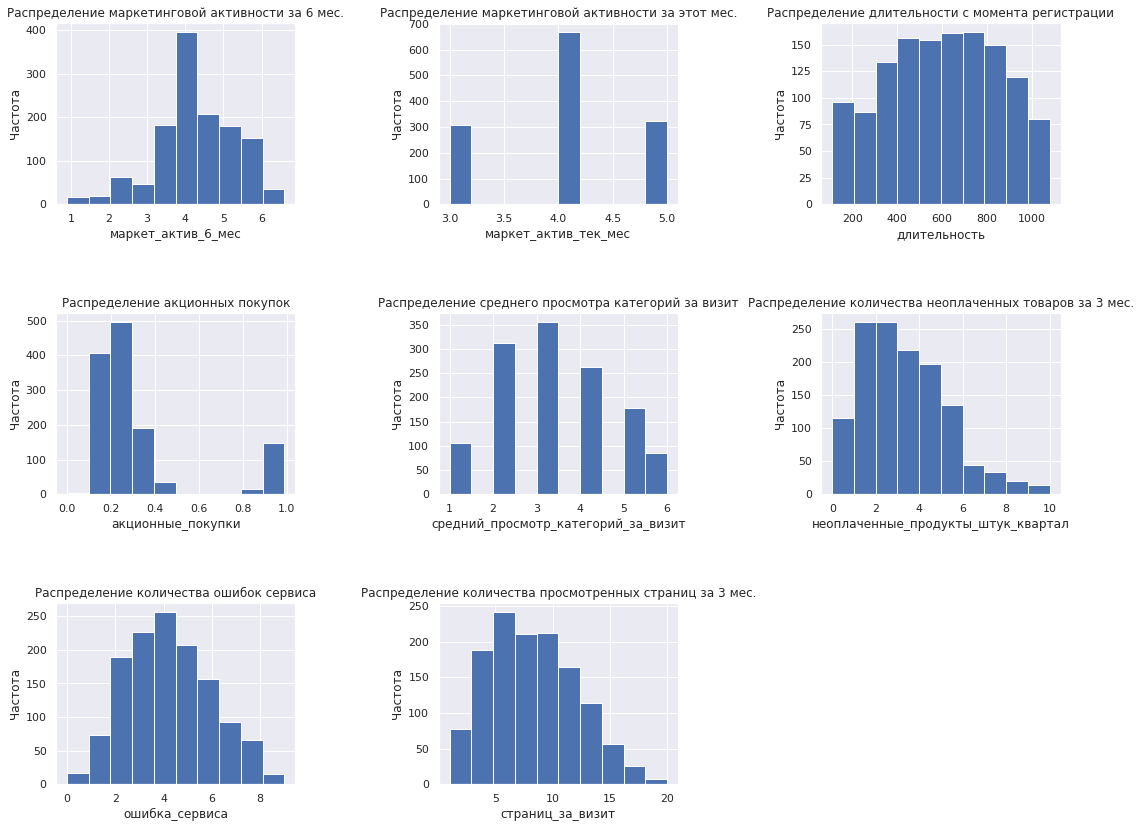

In [23]:
customer_data_titles = ['Распределение маркетинговой активности за 6 мес.',
                    'Распределение маркетинговой активности за этот мес.',
                    'Распределение длительности с момента регистрации',
                    'Распределение акционных покупок',
                    'Распределение среднего просмотра категорий за визит',
                    'Распределение количества неоплаченных товаров за 3 мес.',
                    'Распределение количества ошибок сервиса',
                    'Распределение количества просмотренных страниц за 3 мес.'
                   ]

num_vals_distribution(customer_data, customer_data_titles, customer_data_num_cols, (18, 14), 1)

По графикам видно, что во всех столбцах кроме *акционные_покупки* данные распеделены нормально

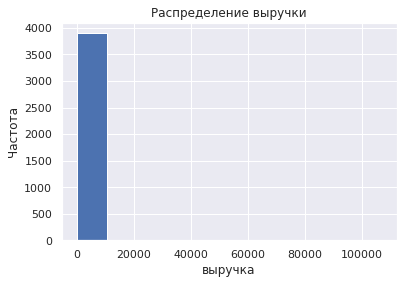

In [24]:
overall_income_data['выручка'].hist()
plt.title('Распределение выручки')
plt.xlabel('выручка')
plt.ylabel('Частота')
plt.show();

По графику явно заметно наличие выбросов в данных

In [25]:
overall_income_data[overall_income_data['выручка'] > 20000]

,id,период,выручка
98,215380,текущий_месяц,106862.2


Значение выручки значительно превосходит среднее, а также вряд ли является ошибкой программы, так как даже при уменьшении значения в 10 раз, оно также будет намного больше остальных значений, так что я предлагаю удалить данное значение 

In [26]:
overall_income_data = overall_income_data[overall_income_data['выручка'] < 20000]

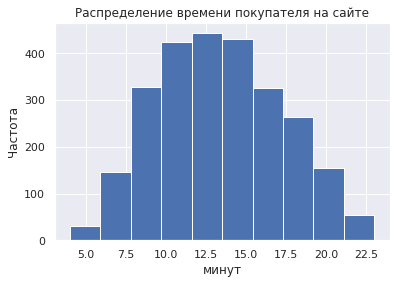

In [27]:
customer_time_data['минут'].hist()
plt.title('Распределение времени покупателя на сайте')
plt.xlabel('минут')
plt.ylabel('Частота')
plt.show();

Всё хорошо, распределение нормальное

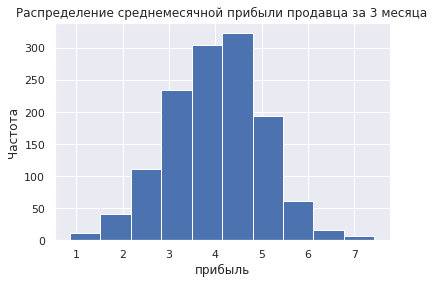

In [28]:
avg_income_data['прибыль'].hist()
plt.title('Распределение среднемесячной прибыли продавца за 3 месяца')
plt.xlabel('прибыль')
plt.ylabel('Частота')
plt.show();

Распределение, близкое к нормальному

Посмотрим на распределение данных в количественных признаках

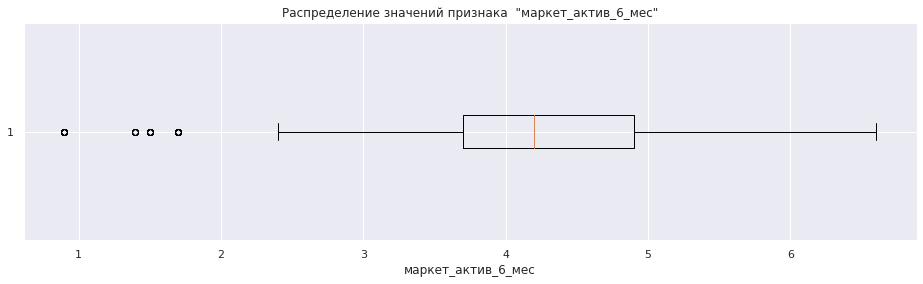

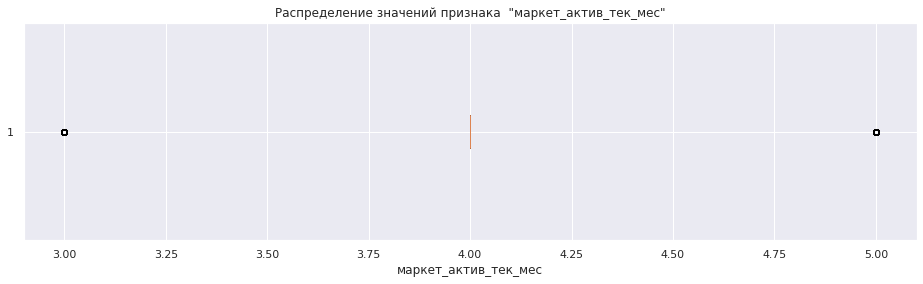

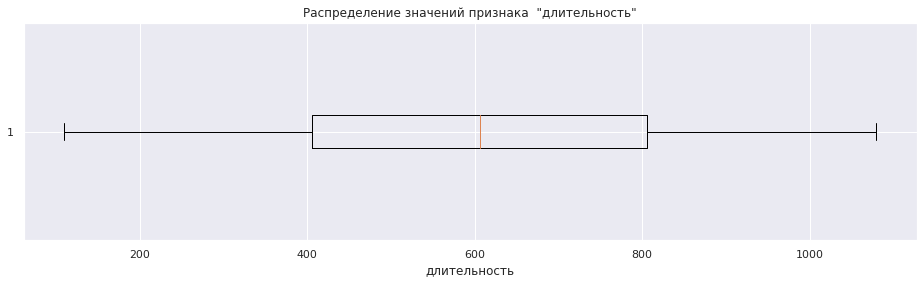

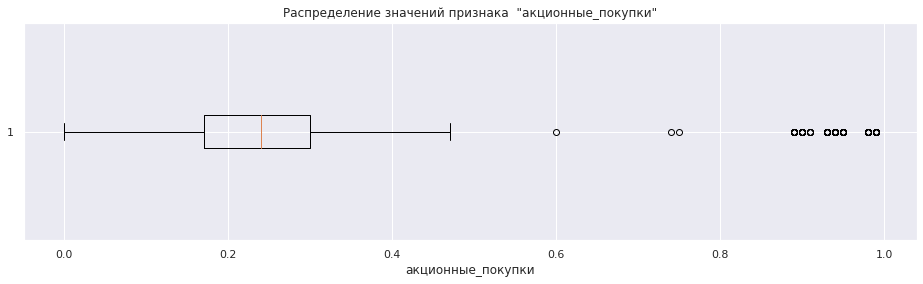

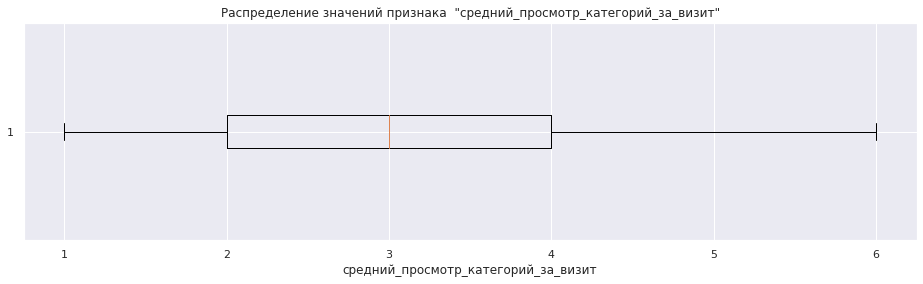

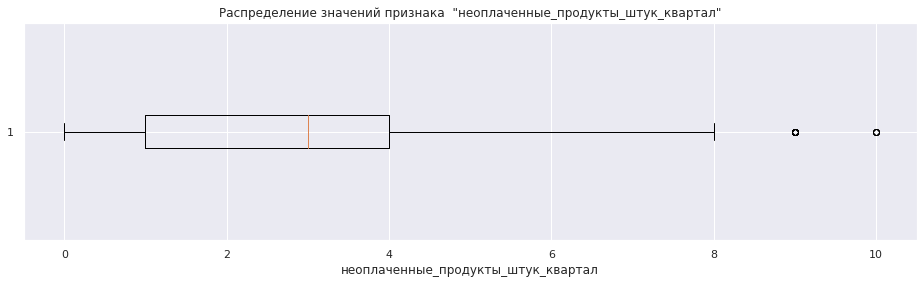

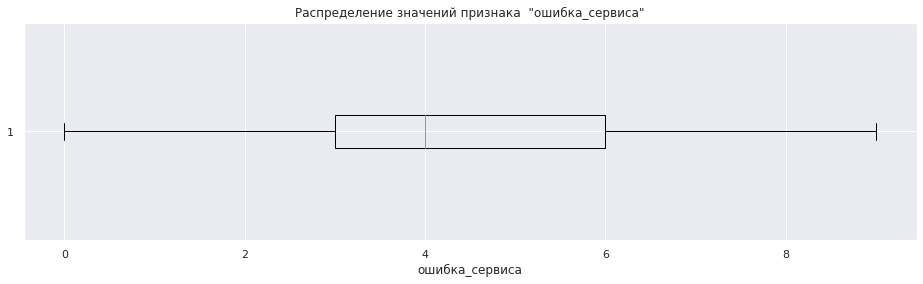

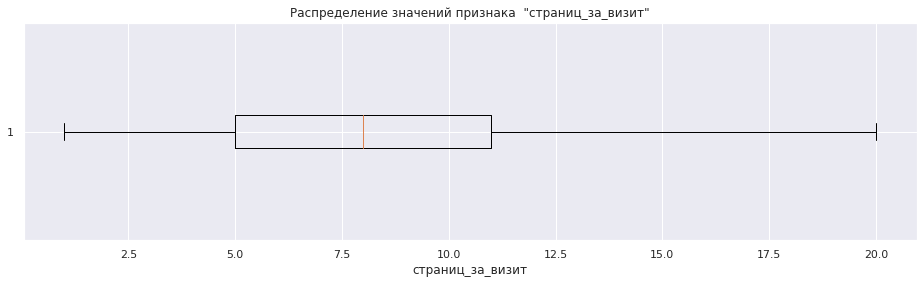

In [29]:
for column in customer_data_num_cols:
    plt.figure(figsize=(16,4))
    
    plt.boxplot(customer_data[column], vert=False)
    
    plt.title(f'Распределение значений признака  "{column}"')
    plt.xlabel(column)
    plt.show();

График распределения показывает нам выбросы в этих признаках:

- *маркет_актив_6_мес* (значения < 2)
- *неоплаченные_продукты_штук_квартал* (больше 8)

В то же время на графиках представлены отдельные группы значений(например в *акционные_покупки* и *маркет_актив_тек_мес*), которые обособлены от общей массы значений, но не являются выбросами, так как представляют большую группу значений

Избавимся от выбросов

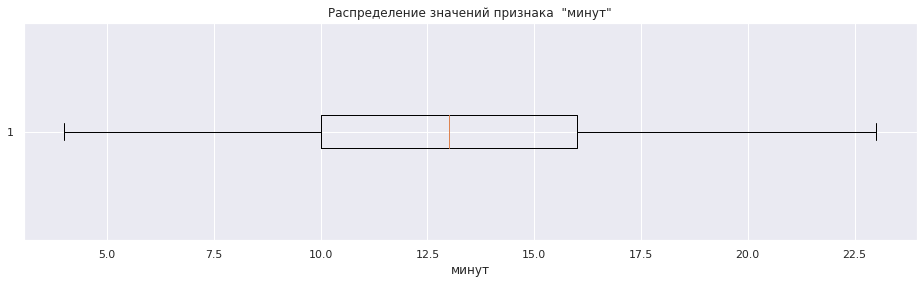

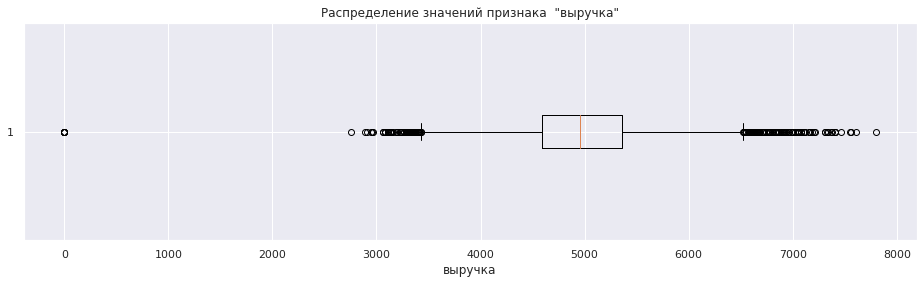

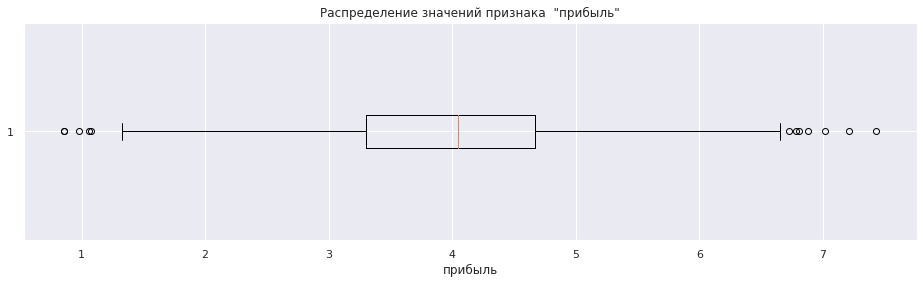

In [30]:
dist_tables = [customer_time_data, overall_income_data, avg_income_data]
dist_tables_labels = ['минут', 'выручка', 'прибыль']
for i in range(len(dist_tables)):
    plt.figure(figsize=(16,4))
    
    plt.boxplot(dist_tables[i][dist_tables_labels[i]], vert=False)
    
    plt.title(f'Распределение значений признака  "{dist_tables_labels[i]}"')
    plt.xlabel(dist_tables_labels[i])
    plt.show();

В признаке *выручка* присутствуют значения, равные нулю, которые к тому же являются выбросами; в признаке *прибыль* значения меньше 1.2 или большие 7 отбиваются от общей массы данных.

Избавимся от этих выбросов

In [31]:
overall_income_data = overall_income_data[overall_income_data['выручка'] != 0]
avg_income_data = avg_income_data[(avg_income_data['прибыль'] > 1.2) & ((avg_income_data['прибыль'] < 7))]

<a id="target_div"></a> 
Перейдём к изучению распределения данных категориальных признаков

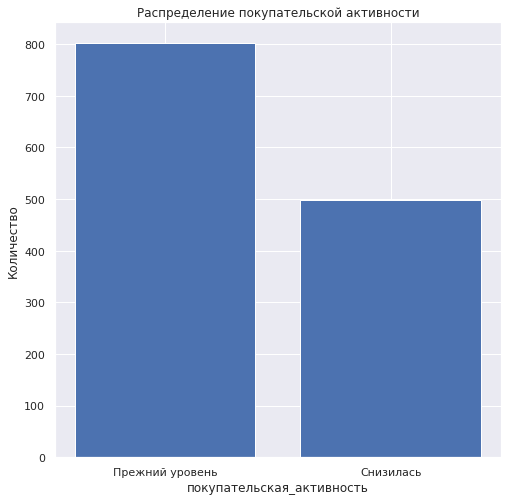

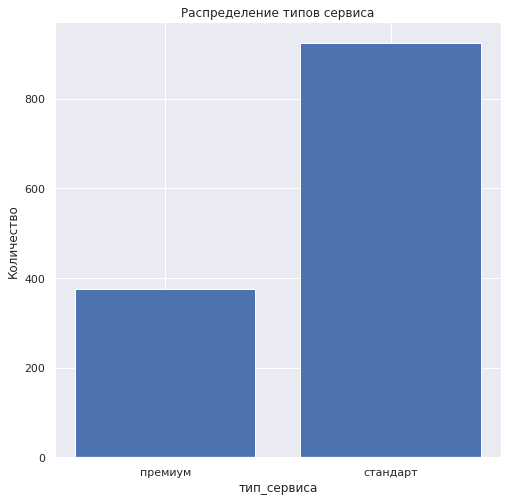

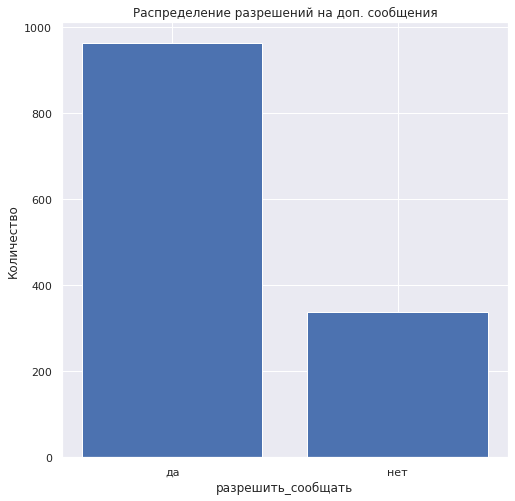

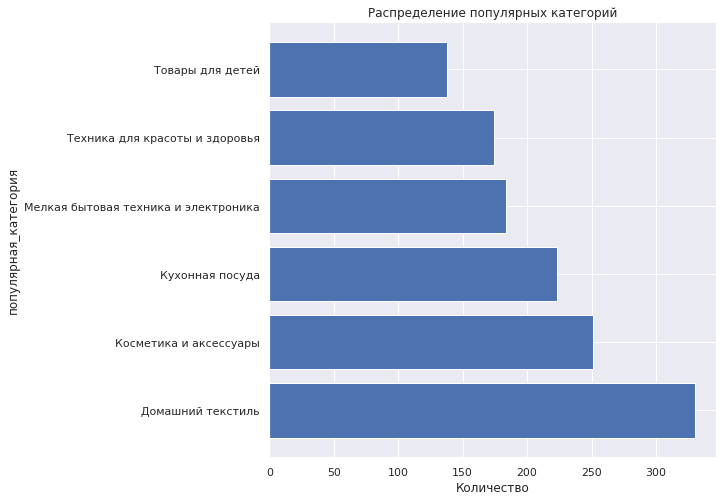

In [32]:
obj_titles = ['покупательской активности', 'типов сервиса', 'разрешений на доп. сообщения', 'популярных категорий']

for i in range(len(customer_data_obj_cols)):
    plt.figure(figsize=(8, 8))
    
    obj_data_count = customer_data.groupby(customer_data_obj_cols[i])[customer_data_obj_cols[i]].count()
    
    if customer_data_obj_cols[i] != 'популярная_категория':
        
        plt.bar(obj_data_count.index, obj_data_count)
        
        plt.title(f'Распределение {obj_titles[i]}')
        plt.xlabel(customer_data_obj_cols[i])
        plt.ylabel('Количество')
        
    else:
        
        plt.barh(obj_data_count.index, obj_data_count.sort_values(ascending=False))
        
        plt.title(f'Распределение {obj_titles[i]}')
        plt.ylabel(customer_data_obj_cols[i])
        plt.xlabel('Количество')
        
    plt.show();

Можно сделать выводы, что:

- у большинства покупателей(61%) покупательская активность соответствует прежнему уровню,
- стандарт сервис значительно популярнее премиум сервиса,
- большинство покупателей(70%) согласны на получение доп. сообщений,
- "Домашний текстиль" является самой популярной категорией товаров

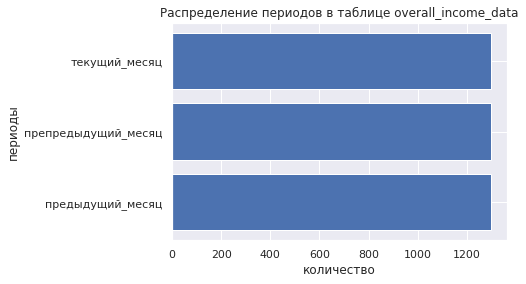

In [33]:
overall_income_data_count = overall_income_data.groupby('период')['период'].count()

plt.barh(overall_income_data_count.index, overall_income_data_count)
plt.title('Распределение периодов в таблице overall_income_data')
plt.ylabel('периоды')
plt.xlabel('количество')
plt.show();

Периоды распределены равномерно

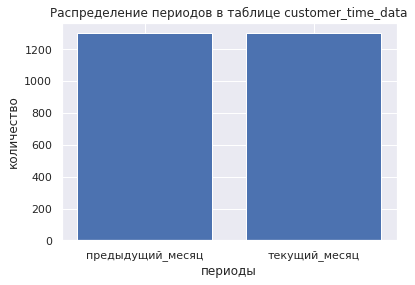

In [34]:
customer_time_data_count = customer_time_data.groupby('период')['период'].count()

plt.bar(customer_time_data_count.index, customer_time_data_count)
plt.title('Распределение периодов в таблице customer_time_data')
plt.xlabel('периоды')
plt.ylabel('количество')
plt.show();

Распределение идентично

**В ходе исследовательского анализа данных:**

- было графически предаставлено распределение значений признаков всех таблиц,
- были обнаружены и удалены выбросы в разных таблицах,
- сделаны выводы о распределении значений в категориальных признаках

<a id="shag5"></a> 
## Объединение таблиц

Объединим таблицы **customer_data**, **overall_income_data**, **customer_time_data** в таблицу **market_data** для последующего машинного обучения

Однако прусутствует проблема: в таблице **customer_time_data** есть только 2 периода, в то время как в **overall_income_data** их целых 3. Объединение этих таблиц приведёт к огромному количеству пропусков в итоговой таблице. Кроме того, на каждого покупателя приходится сразу несколько периодов.

Чтобы не допустить этого, сделаем новые столбцы в таблицах **customer_time_data** и **overall_income_data**, значения которых будут привязаны только к одному покупателю, однако они всё также будут отражать изначальные данные

In [35]:
time_present_month = customer_time_data[customer_time_data['период'] == 'текущий_месяц'][['id','минут']]
time_prev_month = customer_time_data[customer_time_data['период'] == 'предыдущий_месяц'][['id','минут']]
overall_time = pd.DataFrame(customer_time_data.groupby('id')['минут'].sum()).reset_index()

In [36]:
customer_time_behaviour = pd.merge(time_present_month, time_prev_month, how='inner', on='id')
customer_time_behaviour = pd.merge(customer_time_behaviour, overall_time, how='inner', on='id')
customer_time_behaviour.rename({'минут_x': 'время_за_тек_мес',
                                'минут_y': 'время_за_пред_мес',
                                'минут': 'общее_время'}, axis=1, inplace=True)

Так, была создана таблица **customer_time_behaviour**, в которой записаны время за текущий и за прошедший месяцы для каждого пользователя

In [37]:
income_present_month = overall_income_data[overall_income_data['период'] == 'текущий_месяц'][['id', 'выручка']]
income_prev_month = overall_income_data[overall_income_data['период'] == 'предыдущий_месяц'][['id', 'выручка']]
income_preprev_month = overall_income_data[overall_income_data['период'] == 'препредыдущий_месяц'][['id', 'выручка']]
_ = pd.merge(income_present_month, income_prev_month, how='inner', on='id')

In [38]:
customer_finance_behaviour = pd.merge(_, income_preprev_month, how='inner', on='id')
customer_finance_behaviour['разница_в_выруч_тек_предыдущ'] = customer_finance_behaviour['выручка_x'] - customer_finance_behaviour['выручка_y']
customer_finance_behaviour['разница_в_выруч_предыдущ_препредыдущ'] = customer_finance_behaviour['выручка_y'] - customer_finance_behaviour['выручка']
customer_finance_behaviour = customer_finance_behaviour.rename({'выручка_x': 'выручка_тек_мес'}, axis=1).drop(['выручка_y', 'выручка'], axis=1)

Аналогично была создана таблица **customer_finance_behaviour**, где присутствуют данные о выручке от пользователя за текущий месяц, а также разницы межу текущей и предыдущей  и  предыдущей и предпредыдущей выручками

Объединим таблицы

In [39]:
market_data = pd.merge(customer_data, customer_time_behaviour, how='inner', on='id')
market_data = pd.merge(market_data, customer_finance_behaviour, how='inner', on='id')

Итоговая таблица:

In [40]:
market_data

,id,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,время_за_тек_мес,время_за_пред_мес,общее_время,выручка_тек_мес,разница_в_выруч_тек_предыдущ,разница_в_выруч_предыдущ_препредыдущ
0,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,10,12,22,4971.6,-244.4,744.0
1,215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,13,8,21,5058.4,-399.1,631.5
2,215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,13,11,24,6610.4,452.4,1365.0
3,215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,11,8,19,5872.5,65.0,1213.5
4,215353,Снизилась,стандарт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4,10,10,20,5388.5,650.0,-385.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1291,216643,Прежний уровень,стандарт,да,6.6,3,318,0.24,Техника для красоты и здоровья,5,3,3,11,7,14,21,4741.7,1077.7,-1040.0
1292,216644,Прежний уровень,стандарт,нет,5.1,4,454,0.21,Домашний текстиль,6,2,3,9,11,12,23,5353.0,624.0,-570.0
1293,216645,Прежний уровень,стандарт,да,4.1,3,586,0.20,Домашний текстиль,3,2,5,7,18,12,30,5139.2,-20.8,-174.0
1294,216646,Прежний уровень,стандарт,да,6.3,5,645,0.12,Техника для красоты и здоровья,3,3,5,7,7,18,25,5224.6,301.6,198.0


In [41]:
market_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1296 entries, 0 to 1295
Data columns (total 19 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   id                                    1296 non-null   int64  
 1   покупательская_активность             1296 non-null   object 
 2   тип_сервиса                           1296 non-null   object 
 3   разрешить_сообщать                    1296 non-null   object 
 4   маркет_актив_6_мес                    1296 non-null   float64
 5   маркет_актив_тек_мес                  1296 non-null   int64  
 6   длительность                          1296 non-null   int64  
 7   акционные_покупки                     1296 non-null   float64
 8   популярная_категория                  1296 non-null   object 
 9   средний_просмотр_категорий_за_визит   1296 non-null   int64  
 10  неоплаченные_продукты_штук_квартал    1296 non-null   int64  
 11  ошибка_сервиса   

**В результате объединения таблиц:**

- три таблицы **customer_data**, **overall_income_data**, **customer_time_data** были объединены в **market_data**,
- признаки начальных таблиц были изменены на признаки, значения которых привязаны только к одному покупателю. Таким образом, были добавлены признаки: *время_за_тек_мес, время_за_пред_мес, общее_время, выручка_тек_мес, разница_в_выруч_тек_предыдущ, разница_в_выруч_предыдущ_препредыдущ*

<a id="shag6"></a> 
## Корреляционный анализ

Произведём корреляционный анализ количественны признаков в полученной таблице

Изменим целовой признак(*покупательская_активность*) на числовой, чтобы произвести анализ корреляции между будущими входными признаками и целевым

In [42]:
market_data['покупательская_активность'] = market_data['покупательская_активность'].apply(lambda x: 1 if x == 'Снизилась' else 0)

interval columns not set, guessing: ['id', 'покупательская_активность', 'маркет_актив_6_мес', 'маркет_актив_тек_мес', 'длительность', 'акционные_покупки', 'средний_просмотр_категорий_за_визит', 'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса', 'страниц_за_визит', 'время_за_тек_мес', 'время_за_пред_мес', 'общее_время', 'выручка_тек_мес', 'разница_в_выруч_тек_предыдущ', 'разница_в_выруч_предыдущ_препредыдущ']


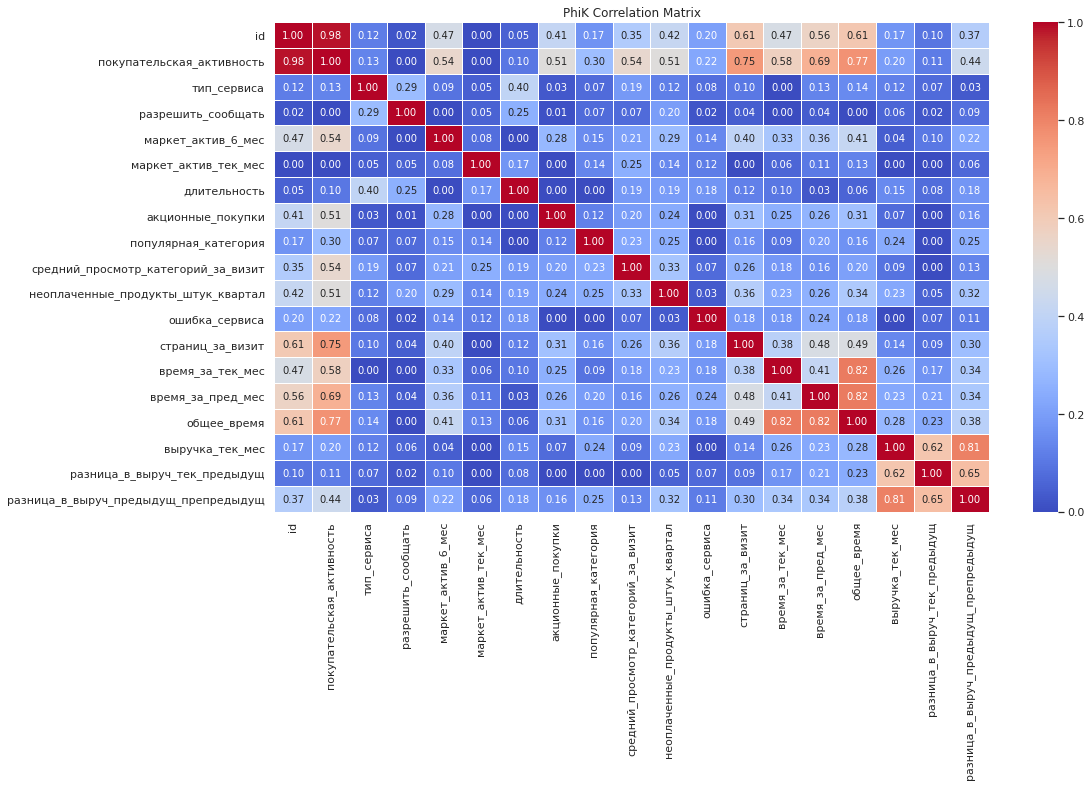

In [43]:
corr_matrix = market_data.phik_matrix()

plt.figure(figsize=(16, 9))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('PhiK Correlation Matrix')
plt.show();

По этой тепловой карте можно сделать вывод, что:

- *покупательская_активность* имеет высокую корреляцию с id пользователя,
- высокая корреляция заметна между признаками *страниц_за_визит*, *время_за_пред_мес*, *общее_время* и целевой переменной,
- признаки *маркет_актив_6_мес*, *акционные_покупки*, *средний_просмотр_категорий_за_визит*, *неоплаченные_продукты_штук_квартал*, *разница_в_выруч_предыдущ_препредыдущ* имеют среднюю корреляцию с целевыми признаком, 
- остальные признаки практически не влияют на целевую переменную,

Теперь проверим количественные признаки на мультиколлинеарность c помощью VIF

In [44]:
market_num_data = market_data.select_dtypes(exclude='object')

market_num_data = add_constant(market_num_data)

vif_data = pd.DataFrame()
vif_data["Признак"] = market_num_data.columns
vif_data["VIF"] = [variance_inflation_factor(market_num_data.values, i) for i in range(market_num_data.shape[1])]
vif_data.iloc[1:]

,Признак,VIF
1,id,3.140484
2,покупательская_активность,3.748120
3,маркет_актив_6_мес,1.251656
4,маркет_актив_тек_мес,1.044993
5,длительность,1.102837
6,акционные_покупки,1.249725
7,средний_просмотр_категорий_за_визит,1.242610
8,неоплаченные_продукты_штук_квартал,1.235776
9,ошибка_сервиса,1.079599
10,страниц_за_визит,1.536109


Как мы можем видеть, VIF параметров с 10 индекса(*время_за_тек_мес*, *время_за_пред_мес*, *общее_время*, *выручка_тек_мес*, *разница_в_выруч_предыдущ_препредыдущ*) имеют либо бесконечный VIF, либо больший 5. Это объясняется тем, что эти переменные - линейные комбинации других переменных. Мы их сами создали на основе полученных данных, поэтому удалять их из-за подозрения на мультиколлинеарность не стоит

Остальные признаки имеют VIF < 5, так что они точно не обладают мультиколлинеарностью

Почему *id* так взаимозависим с покупательской активностью? - Дело в том, как построена таблица: сначала идут пользователи с меньшими id, у которых указана снизившаяся активность, в то же время все покупатели из конца списка имеют прежнюю активность

In [45]:
market_data.head(20)

,id,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,время_за_тек_мес,время_за_пред_мес,общее_время,выручка_тек_мес,разница_в_выруч_тек_предыдущ,разница_в_выруч_предыдущ_препредыдущ
0,215349,1,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,10,12,22,4971.6,-244.4,744.0
1,215350,1,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,13,8,21,5058.4,-399.1,631.5
2,215351,1,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,13,11,24,6610.4,452.4,1365.0
3,215352,1,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,11,8,19,5872.5,65.0,1213.5
4,215353,1,стандарт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4,10,10,20,5388.5,650.0,-385.5
5,215354,1,стандарт,да,5.1,3,431,0.23,Косметика и аксессуары,2,3,7,2,12,11,23,5869.6,184.6,1182.0
6,215355,1,стандарт,нет,4.7,4,284,0.17,Товары для детей,5,1,6,4,10,12,22,3772.6,509.6,-1486.0
7,215356,1,стандарт,да,4.2,4,192,0.14,Косметика и аксессуары,2,2,1,3,7,6,13,4566.4,419.9,-286.5
8,215358,1,стандарт,да,4.7,4,450,0.13,Домашний текстиль,4,2,6,4,10,14,24,4209.5,721.5,-1239.0
9,215360,1,премиум,да,3.9,3,623,0.35,Кухонная посуда,3,1,4,7,6,9,15,5834.9,530.4,-250.5


In [46]:
market_data.tail(20)

,id,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,время_за_тек_мес,время_за_пред_мес,общее_время,выручка_тек_мес,разница_в_выруч_тек_предыдущ,разница_в_выруч_предыдущ_препредыдущ
1276,216628,0,стандарт,нет,3.8,4,467,0.22,Мелкая бытовая техника и электроника,5,1,4,4,14,18,32,5225.0,767.0,-742.0
1277,216629,0,стандарт,нет,3.5,4,346,0.40,Кухонная посуда,3,1,6,7,13,21,34,4148.8,-226.2,-411.0
1278,216630,0,стандарт,да,4.4,4,488,0.29,Домашний текстиль,4,4,7,4,16,17,33,5875.8,553.8,489.0
1279,216631,0,стандарт,да,3.0,3,455,0.24,Кухонная посуда,5,0,7,7,17,17,34,4844.6,262.6,-153.0
1280,216632,0,стандарт,нет,4.0,3,761,0.35,Кухонная посуда,3,0,4,12,23,20,43,4812.6,-133.9,-304.5
1281,216633,0,стандарт,нет,2.4,4,192,0.35,Техника для красоты и здоровья,3,3,6,10,6,20,26,6013.0,702.0,660.0
1282,216634,0,стандарт,да,4.1,4,335,0.40,Техника для красоты и здоровья,3,4,3,7,13,14,27,4289.5,1319.5,-1372.0
1283,216635,0,стандарт,да,0.9,3,932,0.35,Косметика и аксессуары,3,3,8,5,18,12,30,5039.6,587.6,-528.0
1284,216636,0,премиум,да,2.4,4,996,0.23,Кухонная посуда,3,4,5,6,14,10,24,6454.4,809.9,784.5
1285,216637,0,стандарт,да,3.5,3,801,0.22,Техника для красоты и здоровья,5,1,4,6,19,7,26,4923.4,322.4,-22.0


Такое странное распределение данных может привести к ошибкам модели, если тестовые данные не будут соответствовать этому принципу. Следовало бы узнать, почему данные были распределены именно так и будут ли тестовые данные иметь схожие id.

Однако узнать данную инофрмацию, к сожалению, не получится, поэтому следует избавиться от утечки данных и удалить столбец *id*

In [47]:
market_data2 = market_data.copy()
market_data.drop('id', axis=1, inplace=True)

Теперь подробнее изучим влияние количественных параметров на целевую переменную с помощью графиков

In [48]:
market_data_num_cols = market_data.select_dtypes(exclude='object').columns
market_data_obj_cols = market_data.select_dtypes(include='object').columns

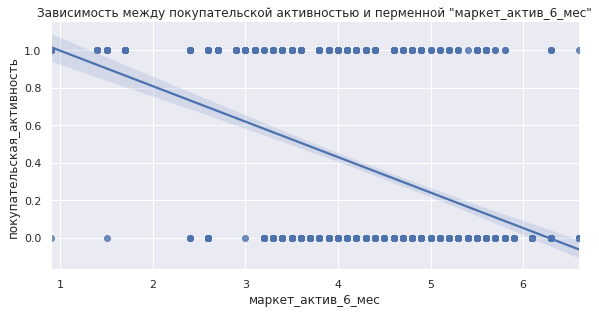

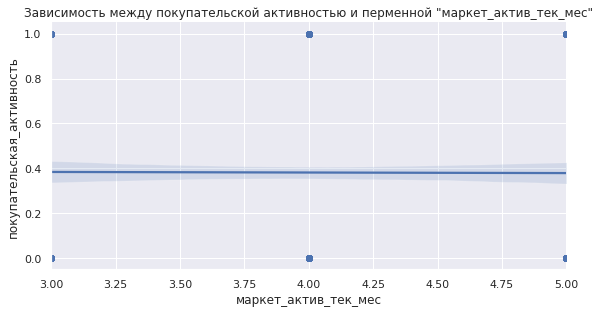

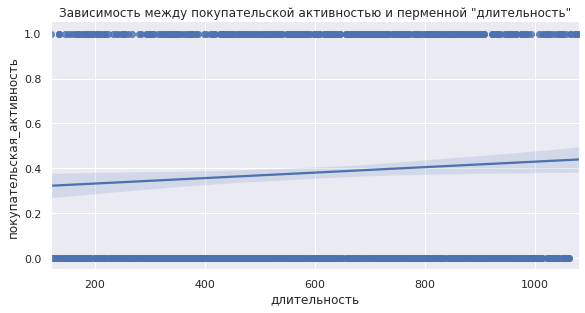

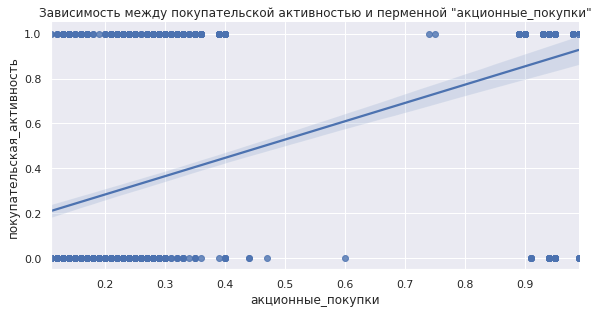

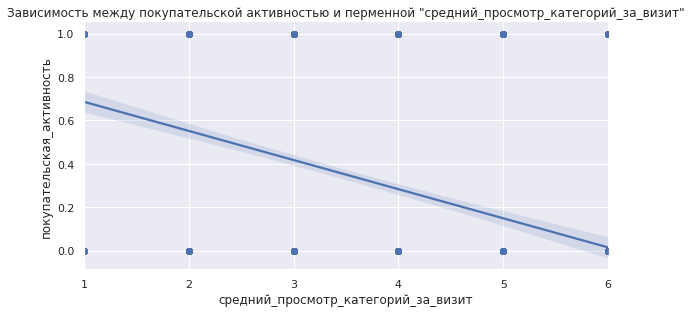

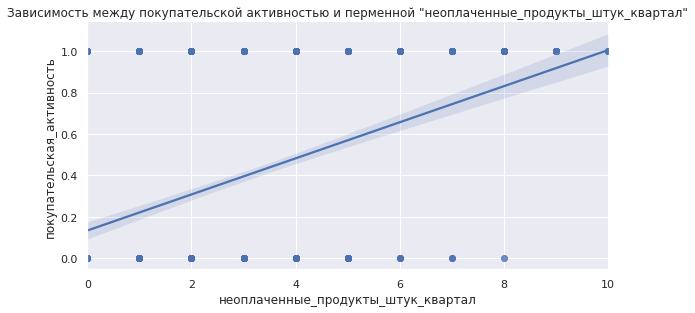

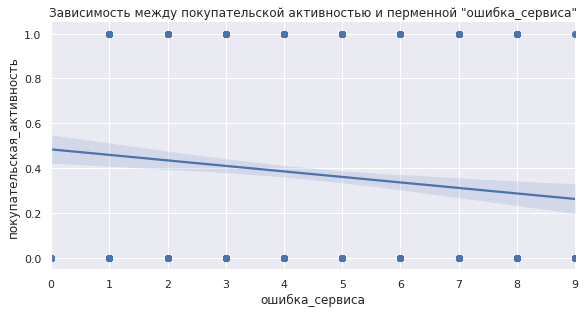

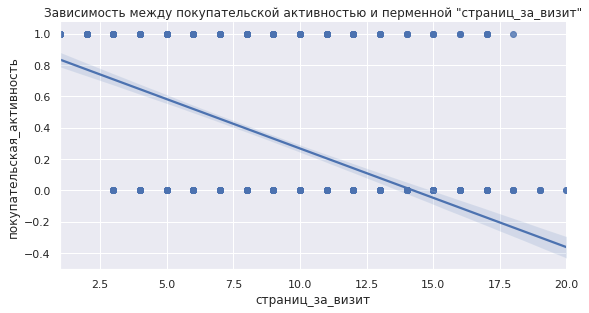

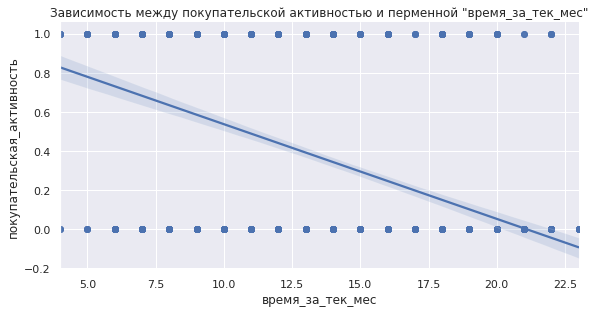

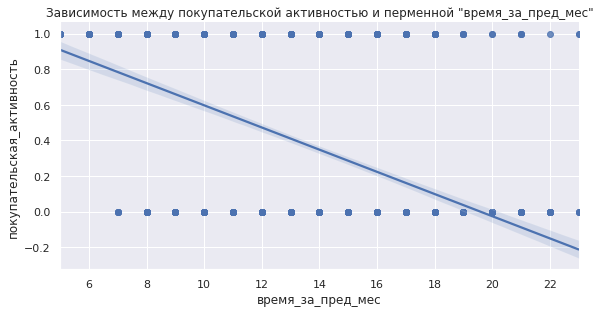

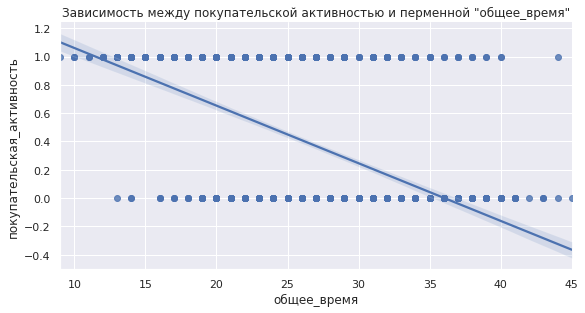

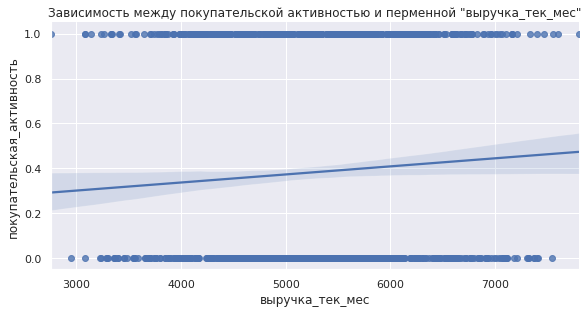

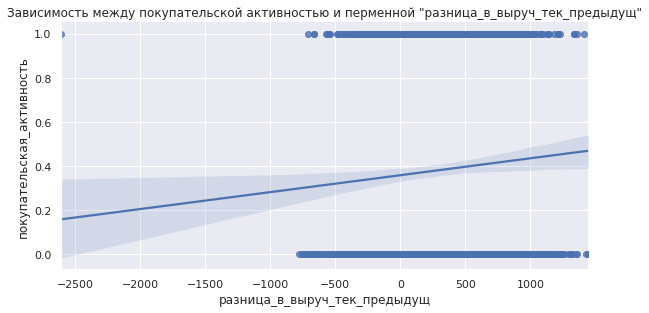

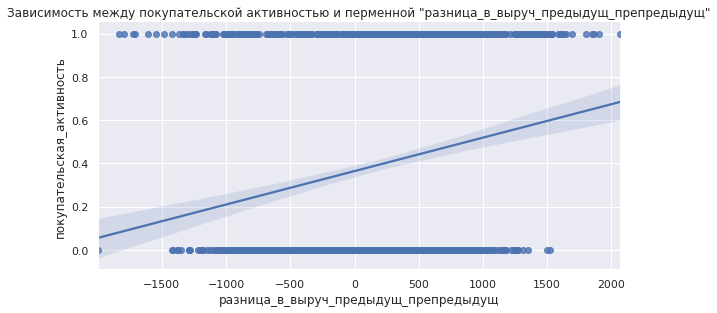

In [49]:
for num_col in market_data_num_cols.drop('покупательская_активность'):
    sns.lmplot(data=market_data, x=num_col, y='покупательская_активность', height=4, aspect=2)
    plt.title(f'Зависимость между покупательской активностью и перменной "{num_col}"')
    plt.show();

Изучим взаимозависимость между категориальными переменными и целевым признаком

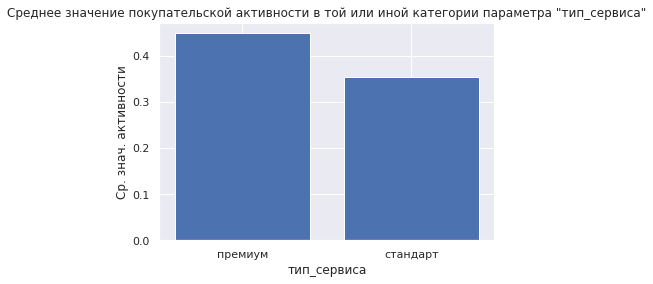

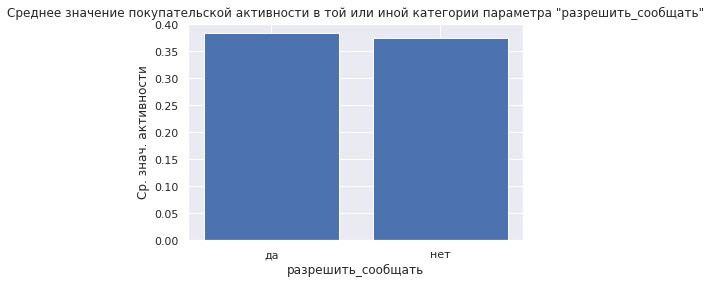

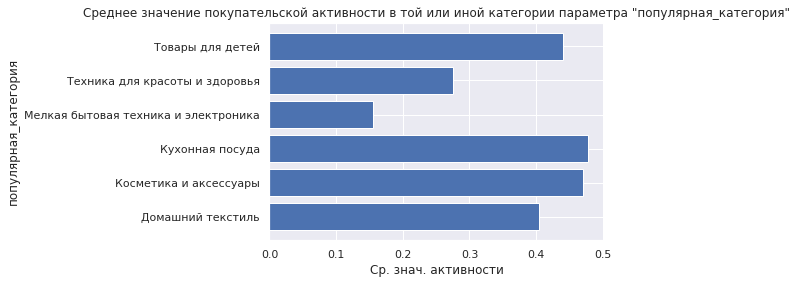

In [50]:
for obj_col in market_data_obj_cols:
    obj_data = market_data.groupby(obj_col)['покупательская_активность'].mean()
    if obj_col != 'популярная_категория':
        plt.bar(obj_data.index, obj_data)
        plt.xlabel(obj_col)
        plt.ylabel('Ср. знач. активности')
    else:
        plt.barh(obj_data.index, obj_data)
        plt.ylabel(obj_col)
        plt.xlabel('Ср. знач. активности')
    plt.title(f'Среднее значение покупательской активности в той или иной категории параметра "{obj_col}"')
    plt.show();

Графики говорят нам о том, что:

- покупатели, у которых *тип_сервиса* "премиум" имеют бОльшую тенденцию к снижению активности,
- покупатели, чья *популярная_категория* это "Техника для красоты и здоровья" или "Мелкая бытовая техника и электроника" чаще остаются на прежнем уровне активности

**В результате корреляционного анализа было выявлено, что**:

- *покупательская_активность* имеет высокую корреляцию с id пользователя. 
- средняя корреляция заметна между признаками *страниц_за_визит*, *время_за_пред_мес*, *общее_время* и целевой переменной,
- признаки *маркет_актив_6_мес*, *акционные_покупки*, *популярная_категория*, *средний_просмотр_категорий_за_визит*, *неоплаченные_продукты_штук_квартал*, *разница_в_выруч_предыдущ_препредыдущ* хоть и имеют корреляцию с целевыми признаком, но она слабая,
- остальные признаки практически не влияют на целевую переменную,
- мультиколлинеарность отсутствует,
- параметр "id" приводит к утечке данных, из-за чего его пришлось удалить,
- покупатели, у которых *тип_сервиса* "премиум" имеют бОльшую тенденцию к снижению активности,
- покупатели, чья *популярная_категория* это "Техника для красоты и здоровья" или "Мелкая бытовая техника и электроника" чаще остаются на прежнем уровне активности

<a id="shag7"></a> 
## Построение моделей машинного обучения

### Создание пайплайна

Разделим признаки на нецелевые и целевой и подготовим тренировочную и тестовую выборки(данных слишком мало, чтобы строить еще и валидационную выборку)

In [51]:
RANDOM_STATE=42

X = market_data.drop('покупательская_активность', axis=1)
y = market_data['покупательская_активность']

X_train, X_test, y_train, y_test = train_test_split(
        X,
        y,
        test_size=0.25,
        random_state=RANDOM_STATE,
        stratify=y
)

Создадим списки с названиями признаков, которые впоследствие будут отмасштабированы и закодированы

Так, для OneHotEncoder() подойдут категориальные признаки *разрешить_сообщать* и *популярная_категория*, значения эьих признаков не обладают естественным порадком.

Для кодирования параметра *тип_сервиса* будем использовать OrdinalEncoder(), так как значение "премиум" лучше, чем "стандарт".

Как мы ранее выяснили, признак *акционные_покупки* содержит множество значений, которые отдичаются от общего объёма данных, так что для масштабирования этого параметра будем использовать MinMaxScaler(), который более чувствителен к выбросам.

Остальные количественные признаки имеют нормальное распределение, так что их кодированием займётся StandardScaler()

In [52]:
ohe_columns = ['разрешить_сообщать', 'популярная_категория']
ord_columns = ['тип_сервиса']
num_columns = X_train.select_dtypes(exclude='object').columns

Создадим пайплайны для подготовки категориальных признаков

In [53]:
ohe_pipe = Pipeline(
    [
        ('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
        ('ohe', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'))
    ]
)

ord_pipe = Pipeline(
    [
        ('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
        ('ord', OrdinalEncoder(
            categories=[['стандарт', 'премиум']]
            )
        ),
        ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
)

Cоздадим общий пайплайн для подготовки данных

In [54]:
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('ord', ord_pipe, ord_columns),
     ('num', MinMaxScaler(), num_columns)
    ], 
    remainder='passthrough'
)

### Отдельное обучение моделей

Создадим пайплайн с моделью DecisionTreeClassifier()

In [55]:
tree_pipe = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

In [56]:
params1 = {
    'preprocessor__num':[StandardScaler(), MinMaxScaler(), 'passthrough'],
    'models__min_samples_leaf': range(3, 6),
    'models__min_samples_split':range(3, 6),
    'models__max_depth':range(3, 10),
    'models__max_features': range(3, 10)
}

В качестве метрики будем исполбзовать 'ROC-AUC', потому что наш целевой признак [несбалансирован](#target_div)

In [57]:
rand_search1 = RandomizedSearchCV(
    tree_pipe,
    params1,
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)

rand_search1.fit(X_train, y_train)

print('Лучшая модель и её параметры:\n\n', rand_search1.best_estimator_)
print ('Метрика модели на кроссвалидационной выборке:', rand_search1.best_score_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['разрешить_сообщать',
                                                   'популярная_категория']),
                                                 ('ord',
                                 

0.85 - отличный результат для модели

Создадим пайплайн с моделью KNeighborClassifier() и проверим его метрику

In [58]:
k_pipe = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', KNeighborsClassifier())
])

params2 = {
    'preprocessor__num':[StandardScaler(), MinMaxScaler(), 'passthrough'],
    'models__n_neighbors': range(2, 20, 2),
    'models__weights':['balanced', 'uniform'],
    'models__metric':['manhattan', 'euclidean', 'chebyshev', 'minkowski']
}

rand_search2 = RandomizedSearchCV(
    k_pipe,
    params2,
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)

rand_search2.fit(X_train, y_train)

print('Лучшая модель и её параметры:\n\n', rand_search2.best_estimator_)
print ('Метрика модели на кроссвалидационной выборке:', rand_search2.best_score_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['разрешить_сообщать',
                                                   'популярная_категория']),
                                                 ('ord',
                                 

Метод k-ближайших соседей показал себя лучше, чем дерево решений на целых 4%

Теперь создадим пайплайн с моделью LogisticRegression() и проверим его метрику

In [59]:
log_pipe = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', LogisticRegression(random_state=RANDOM_STATE))
])

params3 = {
    'preprocessor__num':[StandardScaler(), MinMaxScaler(), 'passthrough'],
    'models__penalty': ['l1', 'l2', 'elasticnet'],
    'models__C':[0.1, 0.3, 0.7, 1, 1.3, 1.6, 2, 3, 4, 5, 6, 8, 10],
    'models__solver':['newton-cg', 'saga', 'liblinear'],
    'models__class_weight': ['None', 'balanced'],
    'models__tol': [1e-6, 1e-5, 1e-4, 1e-3]
}

rand_search3 = RandomizedSearchCV(
    log_pipe,
    params3,
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)

rand_search3.fit(X_train, y_train)

print('Лучшая модель и её параметры:\n\n', rand_search3.best_estimator_)
print ('Метрика модели на кроссвалидационной выборке:', rand_search3.best_score_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['разрешить_сообщать',
                                                   'популярная_категория']),
                                                 ('ord',
                                 

LogisticRegression() показала себя хуже, чем KNeighborsClassifier()

Теперь создадим пайплайн с моделью SVC()

In [60]:
svc_pipe = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', SVC(random_state=RANDOM_STATE, probability=True))
])

params4 = {
    'preprocessor__num':[StandardScaler(), MinMaxScaler(), 'passthrough'],
    'models__C':[0.05, 0.1, 0.3, 0.7, 1, 1.3, 1.6],
    'models__kernel': ['linear', 'rbf', 'poly']
}

rand_search4 = RandomizedSearchCV(
    svc_pipe,
    params4,
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)

rand_search4.fit(X_train, y_train)

print('Модель и её параметры:\n\n', rand_search4.best_estimator_)
print('Параметры модели(поподробнее):\n\n', rand_search4.best_params_)
print('Метрика модели на кроссвалидационной выборке:', rand_search4.best_score_)

Модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['разрешить_сообщать',
                                                   'популярная_категория']),
                                                 ('ord',
                                        

Модель SVC() бьёт рекорды! Метрика ROC-AUC составляет целых 0.897

Проверим лучшую модель(SVC(C=1.6, kernel='poly', probability=True, kernel='poly', random_state=42)), рассчитав её roc_auc_score на тестовом датасете

In [61]:
predicted_probas = rand_search4.predict_proba(X_test)[:, 1]
print('ROC-AUC лучшей модели на тестовой выборке:', roc_auc_score(y_test, predicted_probas))

ROC-AUC лучшей модели на тестовой выборке: 0.907333252437002


Модель показала себя на тестовых данных также хорошо, как и на тестовых

### Поиск лучшей модели через полный пайплайн

Cоздадим итоговый пайплайн с подготовкой данных и моделью

In [62]:
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

Зададим параметры для последующего поиска лучшей модели

In [63]:
params5 = [
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'preprocessor__num':[StandardScaler(), MinMaxScaler(), 'passthrough'],
        'models__min_samples_leaf': range(2, 6),
        'models__min_samples_split':range(2, 6),
        'models__max_depth':range(2, 10),
        'models__max_features': range(2, 10)
    },
    
    {
        'models': [KNeighborsClassifier()],
        'preprocessor__num':[StandardScaler(), MinMaxScaler(), 'passthrough'],
        'models__n_neighbors': range(2, 20, 2),
        'models__weights':['balanced', 'uniform'],
        'models__metric':['manhattan', 'euclidean', 'chebyshev', 'minkowski']  
    },

    {
        'models': [LogisticRegression(random_state=RANDOM_STATE)],
        'preprocessor__num':[StandardScaler(), MinMaxScaler(), 'passthrough'],
        'models__penalty': ['l1', 'l2', 'elasticnet'],
        'models__C':[0.1, 0.3, 0.7, 1, 1.3, 1.6, 2, 3, 4, 5, 6, 8, 10],
        'models__solver':['newton-cg', 'saga', 'liblinear'],
        'models__class_weight': ['None', 'balanced'],
        'models__tol': [1e-6, 1e-5, 1e-4, 1e-3] 
    },
    
    {
        'models': [SVC(random_state=RANDOM_STATE)],
        'preprocessor__num':[StandardScaler(), MinMaxScaler(), 'passthrough'],
        'models__C':[0.05, 0.1, 0.3, 0.7, 1, 1.3, 1.6, 2, 3, 4],
        'models__kernel': ['linear', 'rbf', 'poly']
    }
]

Проведём поиск лучшей модели и её гиперпараметров.

In [64]:
rand_search5 = RandomizedSearchCV(
    pipe_final,
    params5,
    cv=5,
    n_iter=70,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)

rand_search5.fit(X_train, y_train)

print('Лучшая модель и её параметры:\n\n', rand_search5.best_estimator_)
print('Метрика модели на кроссвалидационной выборке:', rand_search5.best_score_)

predicted_probas2 = rand_search5.predict_proba(X_test)[:, 1]
print('ROC-AUC лучшей модели на тестовой выборке:', roc_auc_score(y_test, predicted_probas2))

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['разрешить_сообщать',
                                                   'популярная_категория']),
                                                 ('ord',
                                 

In [65]:
#pd.DataFrame(rand_search5.cv_results_)

Логистическая регрессия добилась лучших результатов в процессе поиска модели через полный пайплайн.

Хотелось бы заметить, что при отдельном обучении модели SVC() мы добились лучших результатов  на тестовой выборке, так что эту модель также стоит держать при себе

**В результате построения модели машинного обучения:**

- был создан пайплайн, который подготавливает данные для модели МО,
- были построены 4 модели МО, среди которых лучший результат показала модель LogisticRegression(C=0.1, class_weight='balanced',random_state=42, solver='saga', tol=0.001)

<a id="shag8"></a> 
## Анализ важности признаков

### Подготовка модели к анализу

Перед анализом важности модели, определим её и обучим на подготовленных данных(но не SVC, a LogisticRegression, т.к. SHAP на ней не работает)

In [66]:
encoder1 = OneHotEncoder(sparse_output=False, drop='first')

# категориальные входные признаки c OHE 
X_ohe = encoder1.fit_transform(X[ohe_columns])
encoder_col_names1 = encoder1.get_feature_names_out()
X_ohe_df = pd.DataFrame(X_ohe, columns=encoder_col_names1)
 
# категориальные входные признаки c OrdinalEncoder
encoder2 = OrdinalEncoder(categories=[['стандарт', 'премиум']])
X_ord = encoder2.fit_transform(X[ord_columns])
X_ord_df = pd.DataFrame(X_ord, columns=ord_columns)


# количественные входные признаки
scaler = StandardScaler()

X_scaled= scaler.fit_transform(X[num_columns])
X_scaled_df = pd.DataFrame(X_scaled, columns=num_columns)

X_ = pd.concat([X_ohe_df, X_ord_df, X_scaled_df], axis=1)

In [67]:
best_model = rand_search5.best_estimator_.named_steps['models']
#features = rand_search5.best_estimator_.named_steps['preprocessor'].get_feature_names_out()    

### SHAP-анализ

Для оценки важности признаков для лучшей модели построим графики важности с помощью метода SHAP

Проанализируем вклад признаков в каждое предсказание модели с помощью shap.plots.beeswarm и shap.plots.waterfall

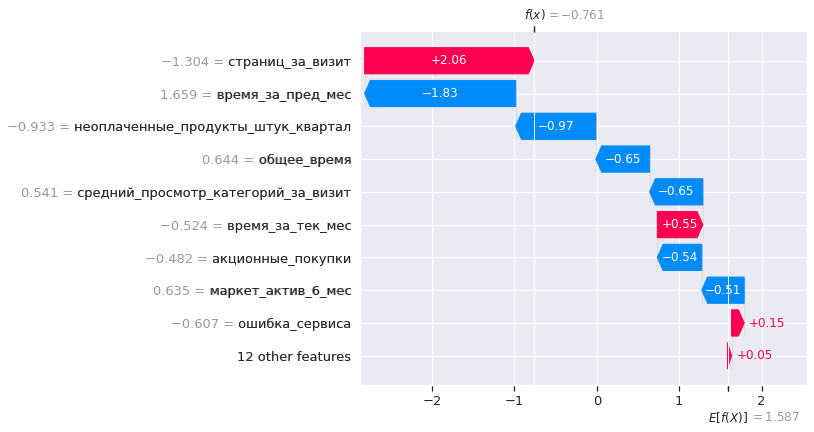

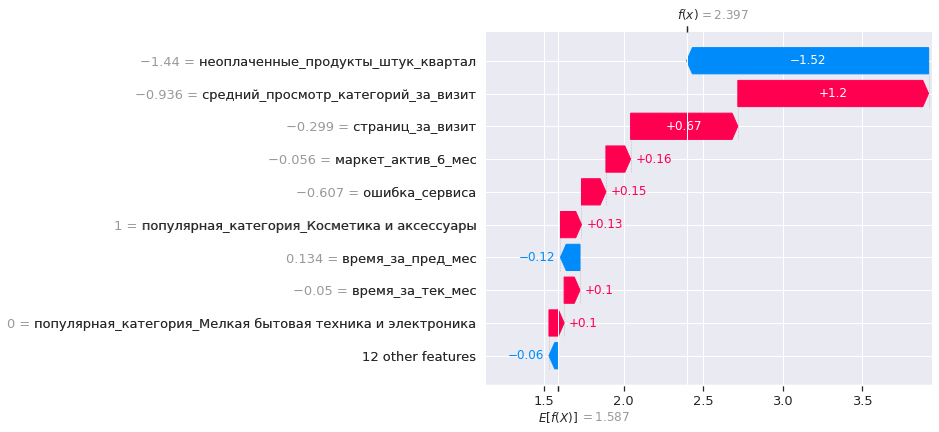

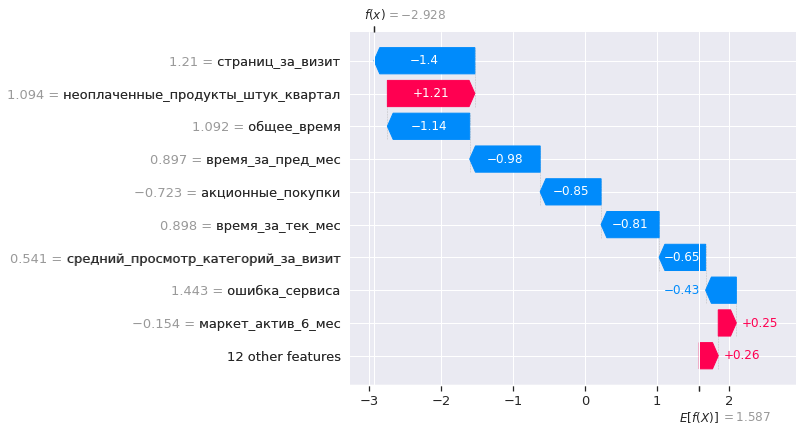

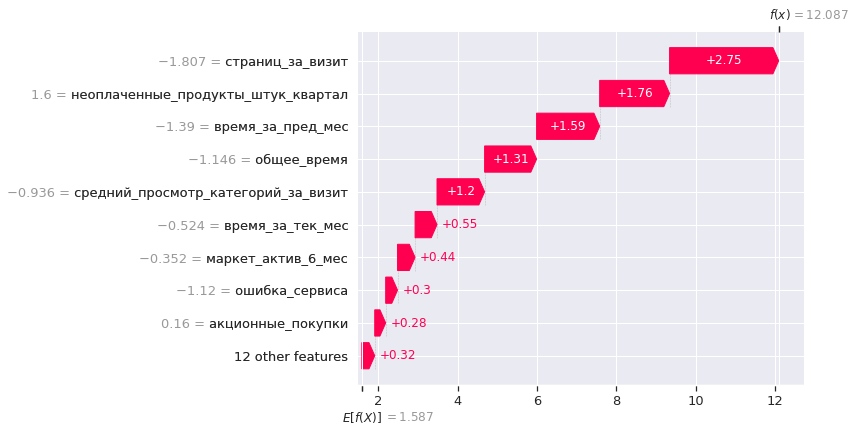

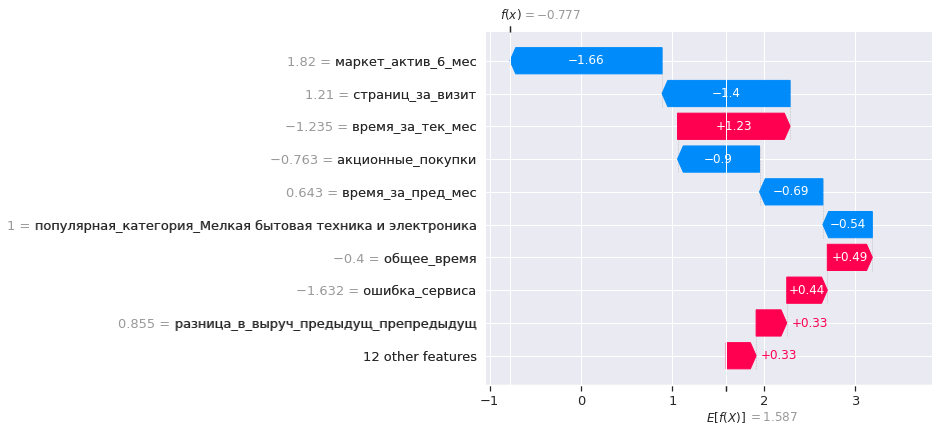

In [68]:
explainer = shap.LinearExplainer(best_model, X_)
shap_values = explainer(X_)

for i in range(5):
    shap.plots.waterfall(shap_values[randint(0, X_.shape[0] - 1)]) 
    plt.show();

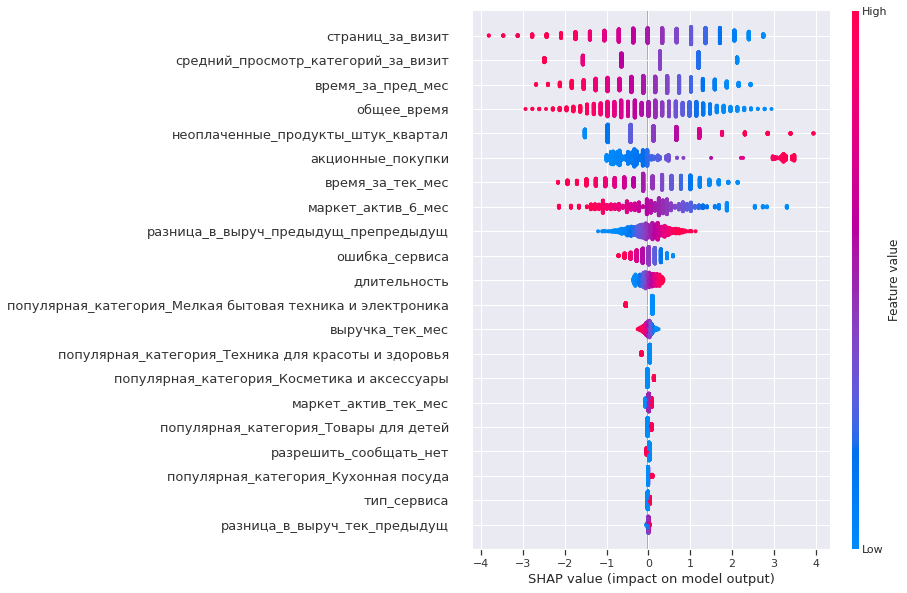

In [69]:
shap.plots.beeswarm(shap_values, max_display=100)

<a id="stock_impact"></a> 
По данным графикам можно сделать вывод, что:

- с точки зрения модели наиболее важными признаками для прогноза активности являюься:*страниц_за_визит*, *средний_просмотр_категорий_за_визит*, *общее_время*, *неоплаченные_продукты_штук_квартал*, *акционные_покупки*, *маркет_актив_6_мес*, *выручка_тек_мес*, *выручка_за_пред_мес*, *разница_в_выруч_предыдущ_препредыдущ*, *длительность*, *x1_Мелкая бытовая техника и электроника* и *x1_Техника для красоты и здоровья*,
- остальные параметры слабо влияют на предсказания модели,
- также нельзя не заметить сильную зависимость большого количество покупок по акциям и покупательской активностью. Так, большое значение параметра *акционные_покупки* даёт нам понять, что с большой вероятностью покупатель снизит свою активность

Таким образом, модель больше всего ориентируется на временное и финансовое поведение покупателя. 

Что же стоит делать бизнесу:

- стараться удержать покупателя на сайте как можно дольше, чтобы за каждый визит пользователь просмотрел как можно больше страниц и категорий,
- минимизировать количество акций для пользователей, у которых и так большое количество акционных покупок,
- предотвращать образование большого количества неоплаченных товаров в корзине покупателя,
- стараться удерживать пользователей, которые уже долгое время взаимодействуют с сайтом,
- чаще рекламировать технические товары покупателям,


<a id="shag9"></a> 
## Сегментация покупателей

### Подготовка данных к сегментации

Добавим в таблицу **market_data** данные о прибыли пользователей из **avg_income_data** и информацию о вероятности снижения покупательской активности с помощью нашей модели

In [70]:
act_prob_list = list(best_model.predict_proba(X_)[:, 1])
act_prob_data = pd.DataFrame({'id': market_data2['id'],
                              'вероятность_снижения_покупательской_активности': act_prob_list})

In [71]:
market_data3 = (
    pd.merge(
        pd.merge(market_data2, avg_income_data, how='inner', on='id'),
        act_prob_data, how='inner', on='id'
    )
)

### Выделение сегментов покупателей

Выделим несколько сегментов покупателей и выберем тот, который будем подробно анализировать

1. Группа клиентов с максимальной долей покупок по акции и высокой вероятностью снижения покупательской активности.

Как мы уже [раньше](#stock_impact) выяснили, пользователи с большой частью акционных покупок чаще снижают свою активность. Проанализируем их и узнаем, можно ли предотвратить снижение покупательской активности

In [72]:
market_data3[(market_data3['акционные_покупки'] > 0.8) & \
             (market_data3['вероятность_снижения_покупательской_активности'] > 0.7)].head()

,id,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,...,ошибка_сервиса,страниц_за_визит,время_за_тек_мес,время_за_пред_мес,общее_время,выручка_тек_мес,разница_в_выруч_тек_предыдущ,разница_в_выруч_предыдущ_препредыдущ,прибыль,вероятность_снижения_покупательской_активности
2,215351,1,стандарт,да,3.2,5,896,0.99,Товары для детей,5,...,6,4,13,11,24,6610.4,452.4,1365.0,4.87,0.998998
3,215352,1,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,...,3,2,11,8,19,5872.5,65.0,1213.5,4.21,0.999982
13,215364,1,премиум,да,4.3,4,708,0.98,Домашний текстиль,3,...,3,3,9,11,20,5484.8,-310.7,853.5,2.67,0.999986
14,215365,1,стандарт,да,3.9,4,167,0.95,Техника для красоты и здоровья,6,...,2,5,10,6,16,4799.3,222.3,387.0,3.65,0.999936
22,215373,1,премиум,нет,3.8,3,811,0.90,Товары для детей,2,...,5,3,8,10,18,5161.1,529.1,339.0,3.69,0.999999


2. Группа клиентов, которые покупают только технику, то есть товары с длинным жизненным циклом.

In [73]:
market_data3.groupby('популярная_категория')['вероятность_снижения_покупательской_активности'].median()

популярная_категория
Домашний текстиль                       0.610326
Косметика и аксессуары                  0.916588
Кухонная посуда                         0.967511
Мелкая бытовая техника и электроника    0.240782
Техника для красоты и здоровья          0.452026
Товары для детей                        0.843368
Name: вероятность_снижения_покупательской_активности, dtype: float64

Как мы можем увидеть, пользователи сайта, покупающие технику имеют намного меньший шанс снижения покупательской активности. Проанализируем этот покупательский сегмент и узнаем больше о постоянных клиентах, чтобы лучше понимать, к чему нужно стремиться в работе с покупателями, предпочитающими другие категории

3. Группа клиентов, которые покупают товары из категории «Товары для себя» (новая категория, которую можно выделить на основе текущих) или «Товары для детей».

Объединив категории "Косметика и аксессуары", "Мелкая бытовая техника и электроника" и "Техника для красоты и здоровья" мы можем получить новую категорию "Товары для себя". Проанализировав пользователей из этой категории мы сможем выявить, как покупка товаров для себя влияет на покупательскую активность клиента

4. Группа клиентов с высокой вероятностью снижения покупательской активности и наиболее высокой прибыльностью.

Одна из задач бизнеса - сохранить и приумножить свою прибыль. Для этого нужно понимать свойства и привычки богатых клиентов. Проанализировав покупателей со сниженной покупательской активности и наиболее высокой прибыльностью мы сможем узнать, почему прибыльные клиенты снижают свою актвность.

In [74]:
market_data3[(market_data3['прибыль'] > 4.5) & \
             (market_data3['вероятность_снижения_покупательской_активности'] > 0.8)].head()

,id,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,...,ошибка_сервиса,страниц_за_визит,время_за_тек_мес,время_за_пред_мес,общее_время,выручка_тек_мес,разница_в_выруч_тек_предыдущ,разница_в_выруч_предыдущ_препредыдущ,прибыль,вероятность_снижения_покупательской_активности
2,215351,1,стандарт,да,3.2,5,896,0.99,Товары для детей,5,...,6,4,13,11,24,6610.4,452.4,1365.0,4.87,0.998998
7,215356,1,стандарт,да,4.2,4,192,0.14,Косметика и аксессуары,2,...,1,3,7,6,13,4566.4,419.9,-286.5,4.93,0.999948
9,215360,1,премиум,да,3.9,3,623,0.35,Кухонная посуда,3,...,4,7,6,9,15,5834.9,530.4,-250.5,4.55,0.999171
17,215368,1,премиум,да,3.8,5,829,0.24,Техника для красоты и здоровья,2,...,6,1,9,11,20,5591.6,-231.4,1287.0,6.27,0.999836
32,215384,1,стандарт,да,4.0,4,1020,0.34,Косметика и аксессуары,2,...,8,3,12,11,23,4010.4,426.4,-642.0,4.78,0.998971


### Анализ сегмента

Для своего анализа я выберу группу  клиентов с максимальной долей покупок по акции и высокой вероятностью снижения покупательской активности

In [75]:
segment_data = market_data3[(market_data3['акционные_покупки'] > 0.8) & \
             (market_data3['вероятность_снижения_покупательской_активности'] > 0.8)].drop('id', axis=1)

In [76]:
segment_data.shape

(151, 20)

К сожалению, таких покупателей не так уж и много, чтобы говорить о каких-то четких выводах о сегменте. Однако, если мы проанализируем эти данные, то сможем выявить какую-то тенденцию

Проведём сравнение значений выборки клиентов с прежней покупательской активностью и выбранного сегмента

In [77]:
segment_data_titles = [
    'Распределение покупательской активности',
    'Распределение маркетинговой активности за 6 мес.',
    'Распределение маркетинговой активности за этот мес.',
    'Распределение длительности с момента регистрации',
    'Распределение акционных покупок',
    'Распределение ср-го просмотра категорий за визит',
    'Распределение количества неоплаченных товаров за 3 мес.',
    'Распределение количества ошибок сервиса',
    'Распределение кол-ва просмотренных страниц за 3 мес.',
    'Распределение времени, на сайте за этот мес.',
    'Распределение времени, на сайте за прош. мес.',
    'Распределение общего времени на сайте',
    'Распределение выручки за текущий месяц',
    'Распределение разницы в выручке за тек. и пред. мес.',
    'Распределение разницы в выручке за пред. и препред. мес.',
    'Распределение прибыли с покупателся',
    'Распределение вероятности снижения покуп. активности'
    ]

segment_data_num_cols = segment_data.select_dtypes(exclude='object').columns 

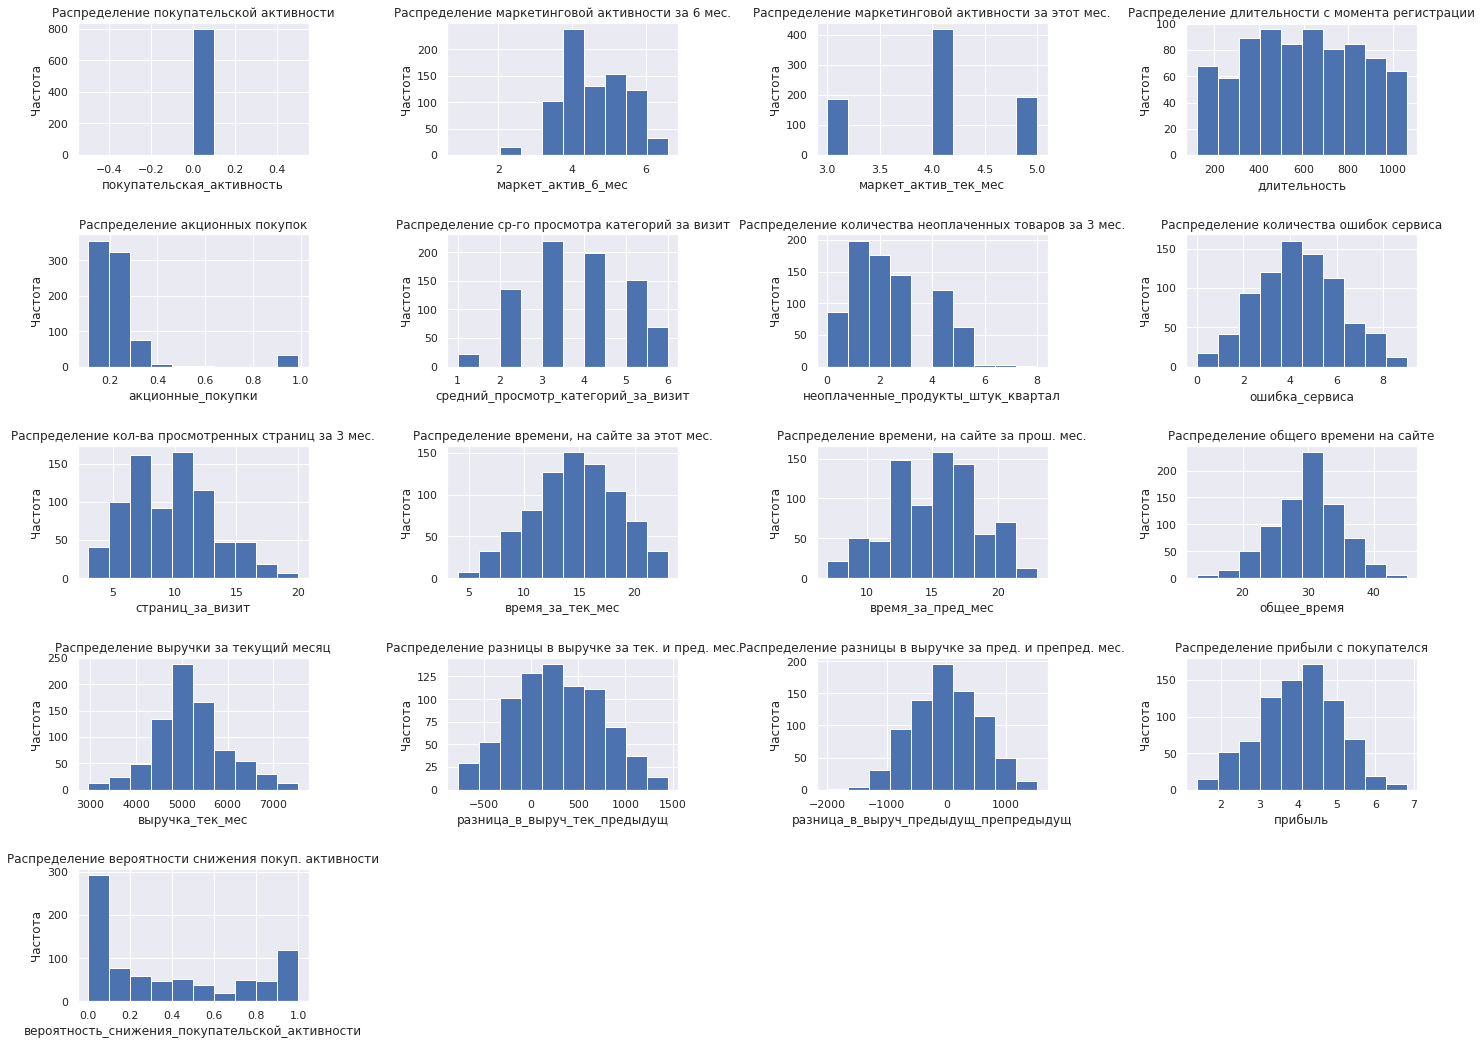

In [78]:
num_vals_distribution(market_data3[market_data3['покупательская_активность'] == 0]
                                  .drop(['id'], axis=1),
                      segment_data_titles,
                      segment_data_num_cols,
                      (24, 18), 3)

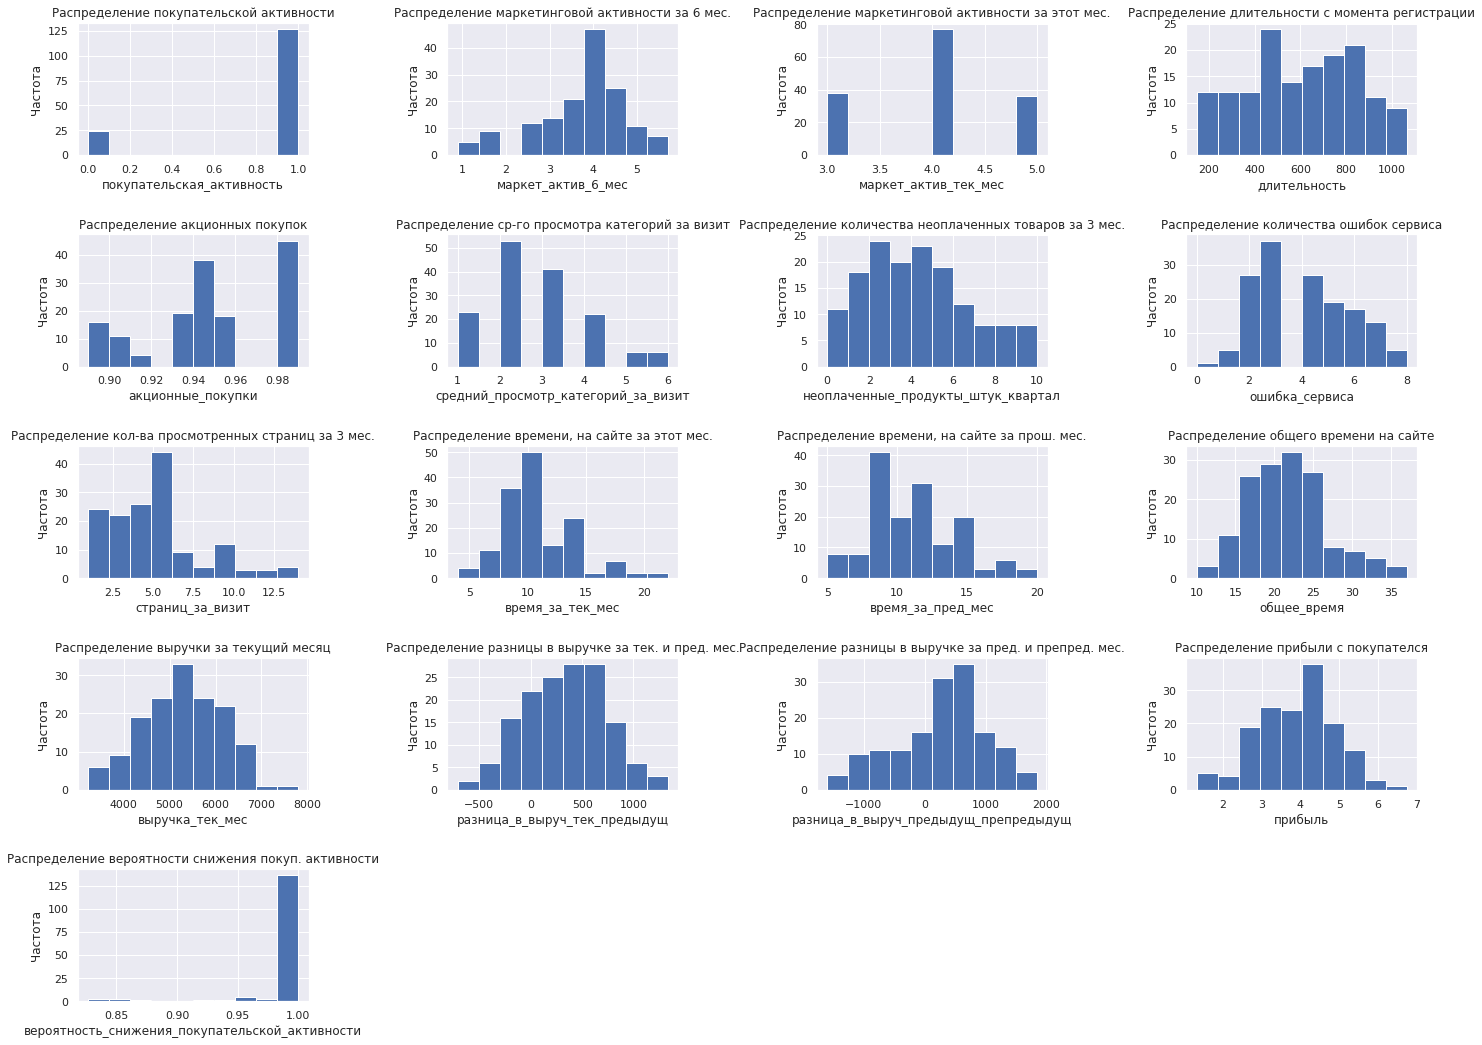

In [79]:
num_vals_distribution(segment_data, segment_data_titles, segment_data_num_cols, (24, 18), 3)

Какие выводы можно сделать о покупателях-любителях товаров по акциям, взглянув на эти графики:

- несмотря на большую вероятность снижения активности существуют покупатели, которые даже при высокой доле акционных покупок имеют прежнюю покупательскую активность,
- намного больше товаров пользователи оставляют в корзинах неоплаченными,
- такие покупатели просматривают намного меньше страниц и категорий за визит, чем другие пользователи,
- они проводят меньше времени на сайте,
- их показатели прибыли схожи с теми, которые наблюдаются у пользователей с прежней активностью

Разберёмся с тем, почему несмотря на большую вероятность снижения покупательской активности некоторые пользователи имеют прежнюю активность

In [80]:
segment_data[segment_data['покупательская_активность'] == 0]

,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,время_за_тек_мес,время_за_пред_мес,общее_время,выручка_тек_мес,разница_в_выруч_тек_предыдущ,разница_в_выруч_предыдущ_препредыдущ,прибыль,вероятность_снижения_покупательской_активности
982,0,стандарт,да,4.9,3,854,0.99,Техника для красоты и здоровья,2,0,4,6,22,14,36,4984.0,273.0,-165.0,5.15,0.832578
998,0,стандарт,да,5.5,4,1022,0.91,Мелкая бытовая техника и электроника,3,0,3,11,6,13,19,6071.6,529.1,460.5,3.26,0.992008
999,0,стандарт,нет,4.1,4,184,0.99,Кухонная посуда,3,4,5,7,15,16,31,6658.6,958.1,955.5,5.02,0.994918
1006,0,стандарт,нет,3.6,4,514,0.95,Товары для детей,4,4,5,13,12,13,25,4375.1,828.1,-805.0,3.10,0.989222
1013,0,стандарт,нет,3.3,3,414,0.94,Домашний текстиль,2,1,5,9,10,14,24,5699.2,336.7,238.5,5.35,0.998989
1024,0,стандарт,да,4.3,5,748,0.95,Косметика и аксессуары,3,1,6,6,7,19,26,5134.2,310.7,208.5,4.65,0.996093
1026,0,стандарт,нет,3.9,5,789,0.94,Техника для красоты и здоровья,4,1,6,10,14,15,29,4975.5,708.5,-667.0,2.13,0.854234
1038,0,стандарт,да,4.2,5,199,0.94,Товары для детей,4,2,6,4,11,14,25,4518.1,672.1,-625.0,4.75,0.996629
1040,0,стандарт,да,3.8,4,265,0.95,Техника для красоты и здоровья,5,2,1,12,9,15,24,5285.7,557.7,-495.0,1.57,0.959997
1054,0,премиум,да,5.2,3,1032,0.95,Мелкая бытовая техника и электроника,3,5,2,11,14,11,25,6254.4,731.9,694.5,4.86,0.997685


In [81]:
segment_data['длительность'].describe()

count     151.000000
mean      602.417219
std       240.986400
min       147.000000
25%       440.000000
50%       618.000000
75%       797.000000
max      1064.000000
Name: длительность, dtype: float64

Можно заметить, что длительность взаимодействия таких пользователей с интернет-магазином намного ниже средней. Возможно, не прошло достаточно времени, чтобы пользователь решил снизить свою активность

Посмотрим, какие категории товаров и типы сервиса предпочитают покупатели акционных товаров

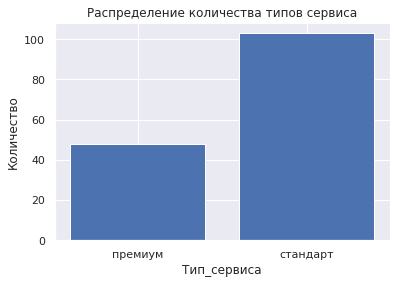

In [82]:
segment_obj_data = segment_data.groupby('тип_сервиса')['тип_сервиса'].count()
plt.bar(segment_obj_data.index, segment_obj_data)
plt.xlabel('Тип_сервиса')
plt.ylabel('Количество')
plt.title('Распределение количества типов сервиса')
plt.show();

Распределение похоже на то, которое мы проводили в процессе исследовательского анализа данных

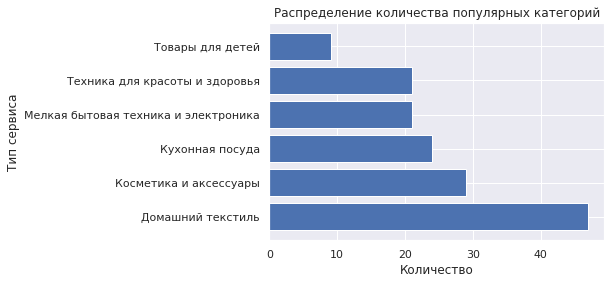

In [83]:
segment_obj_data = segment_data.groupby('популярная_категория')['популярная_категория'].count()
plt.barh(segment_obj_data.index, segment_obj_data.sort_values(ascending=False))
plt.ylabel('Тип сервиса')
plt.xlabel('Количество')
plt.title('Распределение количества популярных категорий')
plt.show();

Распределение похоже на начальное

In [84]:
#segment_data.groupby('популярная_категория')[['выручка_тек_мес', 'разница_в_выруч_тек_предыдущ', 'разница_в_выруч_предыдущ_препредыдущ']].mean()

Посмотрим, зависит ли прибыль от покупательской активности

In [85]:
market_data3[market_data3['покупательская_активность'] == 0]['прибыль'].describe()

count    797.000000
mean       3.999272
std        1.006544
min        1.370000
25%        3.300000
50%        4.040000
75%        4.720000
max        6.810000
Name: прибыль, dtype: float64

In [86]:
segment_data[segment_data['покупательская_активность'] == 1]['прибыль'].describe()

count    127.000000
mean       3.872126
std        0.963852
min        1.330000
25%        3.190000
50%        4.010000
75%        4.425000
max        6.730000
Name: прибыль, dtype: float64

Прибыль сегмента не отличается от прибыли с пользователей с прежней активностью. Интернет-магазину стоит перепроверить данные о прибыли с клиентов

**Предложения по работе с сегментом для увеличения покупательской активности**:

- как уже говорилось ранее, сам факт того, что у покупателя большое количество акционных покупок, говорит нам о том, что через некоторое время его покупательская активность снизится. И это произойдёт, даже если первое время пользователь будет сохранять свою активность. Так что этот сегмент надо уменьшить как можно сильнее,
- следует напоминать пользователям о товарах, которые находятся в корзине и намекать им на их покупку,
- надо стараться удерживать пользователя на сайте как можно дольше. Чем больше страниц и категорий товаров он посмотрит - тем больше шанс того, что покупательская активность останется прежней

**В ходе сегментации покупателей**:

- была создана таблица **market_data3** с подготовленными для сегментации данными(были добавлены столбцы *прибыль* из таблицы **avg_income_data** и *вероятность_снижения_покупательской_активности*(признак, основанный на решениях модели)),
- было выделено 4 сегмента покупателей:

     - Группа клиентов с максимальной долей покупок по акции и высокой вероятностью снижения покупательской активности.
     
     - Группа клиентов, которые покупают только технику, то есть товары с длинным жизненным циклом.
     
     - Группа клиентов, которые покупают товары из категории «Товары для себя» (новая категория, которую можно выделить на основе текущих) или «Товары для детей».
    
     - Группа клиентов с высокой вероятностью снижения покупательской активности и наиболее высокой прибыльностью.
    
- в качестве анализируемого сегмента была выбрана и проанализирована первая из вышеописанных групп,
- были созданы некоторые предложения по увеличению покупательской активности сегмента пользователей с высокой вероятностью снижения активности и максимальной долей покупок по акции:
    - как уже говорилось ранее, сам факт того, что у покупателя большое количество акционных покупок, говорит нам о том, что через некоторое время его покупательская активность снизится. И это произойдёт, даже если первое время пользователь будет сохранять свою активность. Так что этот сегмент надо уменьшить как можно сильнее,
    - следует напоминать пользователям о товарах, которые находятся в корзине и намекать им на их покупку,
    - надо стараться удерживать пользователя на сайте как можно дольше. Чем больше страниц и категорий товаров он посмотрит - тем больше шанс того, что покупательская активность останется прежней

<a id="shag10"></a> 
## Общий вывод

**Задача:**

- Разработать модель, которая предскажет вероятность снижения покупательской активности.
- Выделить сегмент покупателей, проанализировать его и предложить, как увеличить его покупательскую активность.

**Исходные данные:**([Подробнее](#shag1))
- **market_file.csv**.
Таблица, которая содержит данные о поведении покупателя на сайте, о коммуникациях с покупателем и его продуктовом поведении. id — номер покупателя в корпоративной базе данных.
- **market_money.csv**.
Таблица с данными о выручке, которую получает магазин с покупателя, то есть сколько покупатель всего потратил за период взаимодействия с сайтом.
- **market_time.csv**.
Таблица с данными о времени (в минутах), которое покупатель провёл на сайте в течение периода.
- **money.csv**.
Таблица с данными о среднемесячной прибыли продавца за последние 3 месяца: какую прибыль получает магазин от продаж каждому покупателю.

**Проведённая предобработка:**
- были скорректированы названия столбцов таблиц,
- найдены и удалены неявные дубликаты,
- удалены выбросы

**В результате построения модели машинного обучения:**

- был создан пайплайн, который подготавливает данные для модели МО,
- были построены 4 модели МО, среди которых лучший результат показала модель LogisticRegression(C=0.1, class_weight='balanced', random_state=42, solver='saga', tol=0.001)

**В ходе сегментации покупателей:**
- были созданы некоторые предложения по увеличению покупательской активности сегмента пользователей с высокой вероятностью снижения активности и максимальной долей покупок по акции:
    - большое количество акционных покупок, говорит нам о том, что через некоторое время его покупательская активность снизится. И это произойдёт, даже если первое время пользователь будет сохранять свою активность. Так что этот сегмент надо уменьшить как можно сильнее,
    - следует напоминать пользователям о товарах, которые находятся в корзине и намекать им на их покупку,
    - надо стараться удерживать пользователя на сайте как можно дольше. Чем больше страниц и категорий товаров он посмотрит - тем больше шанс того, что покупательская активность останется прежней